In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import tensorflow.keras as keras
import json
import seaborn as sns
import scipy.stats
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import string

In [2]:
plt.rcParams["font.family"] = "Liberation Serif"
plt.rcParams["font.weight"] = "bold"    

In [3]:
def compute_stars(pvalue, alpha, return_level=False):
    """ compute the stars to visualize a p-value """
    PVALUE_STARS = [
        1.,
        1/5.,
        1/50.,
        1/500.
    ]

    for i in range(len(PVALUE_STARS)-1, -1, -1):
        level = PVALUE_STARS[i] * alpha
        if pvalue < level:
            if return_level:
                return i+1, level 
            else:
                return i+1

    return 0

# sGO Terms vs SMF

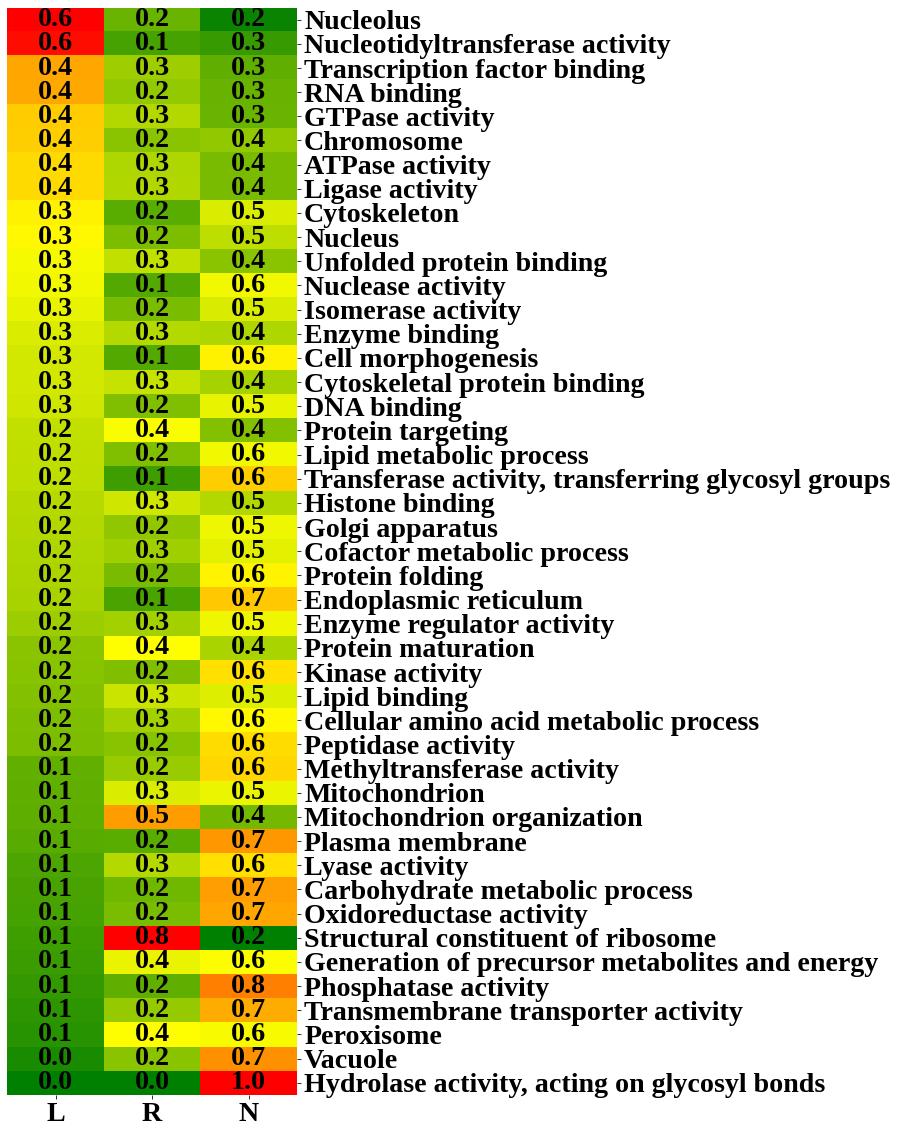

In [4]:
def make_label(s):
    return s[0].upper() + s[1:]

def sgo_terms_vs_smf(task_path):
    
    plot_cfg = {
        "tick_label_size" : 28,
        "xlabel_size" : 60,
        "ylabel_size" : 60,
        "border_size" : 6,
        "bar_border_size" : 2.5,
        "bar_label_size" : 48,
        "stars_label_size" : 48,
        "annot_size" : 24
    }
    
    with open('../generated-data/go_ids_to_names.json', 'r') as f:
        id_to_name = json.load(f)
    
    df = pd.read_feather(task_path)
    
    sdf = df[df.columns[df.columns.str.startswith('sgo-')]]
    
    smf_bin = df['bin']
    
    smf_bin_cat = keras.utils.to_categorical(smf_bin)
    
    sgo_counts = np.dot(np.array(sdf).T, smf_bin_cat)
    sgo_counts = sgo_counts / np.sum(sgo_counts, axis=1, keepdims=True)
    
    cols = [id_to_name[c.replace('sgo-','')] for c in sdf.columns]
    sgo_counts_df = pd.DataFrame(data=sgo_counts, columns=['L', 'R', 'N'], index=cols)
    
    sgo_counts_df.sort_values('L', inplace=True, ascending=False)
    
    vals = np.array(sgo_counts_df[['L', 'R', 'N']])
    orig_vals = vals.copy()

    min_vals = np.min(vals, axis=0, keepdims=True)
    max_vals = np.max(vals, axis=0, keepdims=True)
    vals = (vals - min_vals) / (max_vals - min_vals)

    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])

    f, ax = plt.subplots(1, 1, figsize=(10, 20))
    ax.yaxis.tick_right()
    ax.imshow(vals, aspect=0.25, cmap=cmap)
    plt.setp(ax.spines.values(), linewidth=0, color='black')
    ax.set_yticks(np.arange(sgo_counts_df.shape[0]))
    ax.set_yticklabels([make_label(l) for l in sgo_counts_df.index], fontsize=plot_cfg['tick_label_size'])
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(['L', 'R', 'N'], fontsize=plot_cfg['tick_label_size'])

    for i in range(vals.shape[0]):
        for j in range(vals.shape[1]):
            ax.text(j, i, '%0.1f' % orig_vals[i,j], 
                    color='black', ha="center", va="center", weight='bold', 
                    fontsize=plot_cfg['tick_label_size'])

sgo_terms_vs_smf("../generated-data/dataset_yeast_smf.feather")

# Violin Plot: LID vs SMF

Comparisons: 3, adjusted alpha: 0.016667
L (4.67) vs. R (2.64): 0.000000 [174.830303] (lens 839 vs 994)
L (4.67) vs. N (1.50): 0.000000 [823.436676] (lens 839 vs 2487)
R (2.64) vs. N (1.50): 0.000000 [316.106649] (lens 994 vs 2487)


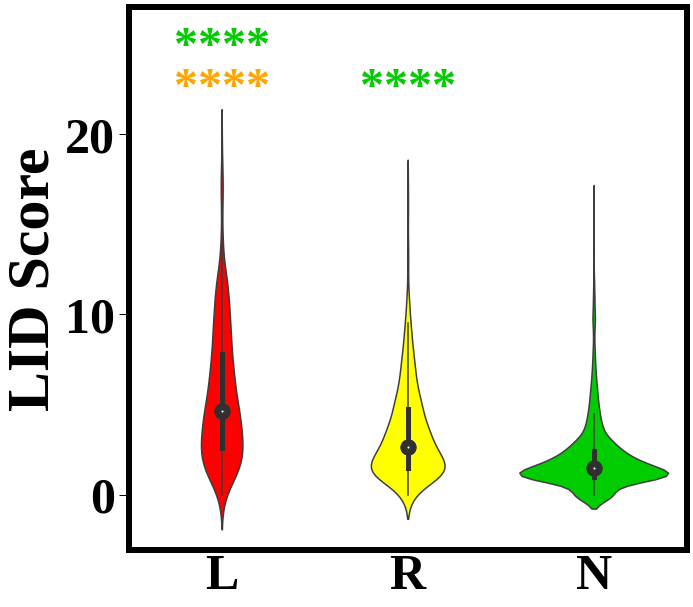

In [5]:
def violin_plot(task_path, feature, ylabel, bins, ylim=None, alpha=0.05, colors=['#FF0000', '#FFFF00', '#00CC00'], star_colors=['#FF0000', 'orange', '#00CC00']):
    plot_cfg = {
        "tick_label_size" : 50,
        "xlabel_size" : 60,
        "ylabel_size" : 60,
        "border_size" : 6,
        "bar_border_size" : 2.5,
        "bar_label_size" : 48,
        "stars_label_size" : 48,
        "annot_size" : 82,
        "iqr_color" : "#303030",

    }
    df = pd.read_feather(task_path)
    df['labeled_bin'] = bins[df['bin'].astype(int)]
    
    f, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax = sns.violinplot(x="labeled_bin", y=feature, ax=ax, order=bins, data=df, 
        palette=colors, saturation=1)
    ax.yaxis.set_tick_params(labelsize=plot_cfg['tick_label_size'])
    ax.xaxis.set_tick_params(labelsize=plot_cfg['tick_label_size'])
    ax.set_ylabel(ylabel, fontsize=plot_cfg['ylabel_size'], weight='bold')
    ax.set_xlabel('')
    ax.set_xlim([-0.5, (len(bins)-0.5)])
    ax.yaxis.set_tick_params(length=10, width=1, which='both')
    ax.xaxis.set_tick_params(length=0)

    max_val = np.max(df[feature])
    if ylim:
        ax.set_ylim(ylim)
    else:
        min_val, max_val = ax.get_ylim()
        ax.set_ylim([min_val, max_val*1.2])
    ax.grid(False)
    plt.setp(ax.spines.values(),linewidth=plot_cfg["border_size"], color='black')
    
    # compute adjusted p-values for pairwise comparisons
    num_comparisons = len(bins) * (len(bins)-1) / 2
    adjusted_alpha = alpha / num_comparisons
    print("Comparisons: %d, adjusted alpha: %f" % (num_comparisons, adjusted_alpha))
    
    
    # increase thickness of median and IQR
    for i in range(len(bins)):
        a = df[df['labeled_bin'] == bins[i]][feature]
        a_med = np.median(a)
        ax.plot([i, i], [a_med, a_med], 'o', color=plot_cfg['iqr_color'], markersize=15)
        iqr_lower = np.percentile(a, 25)
        iqr_upper = np.percentile(a, 75)
        ax.plot([i, i], [iqr_lower, iqr_upper], linewidth=5, color=plot_cfg['iqr_color'])
        
        yoffset = max_val
        
        for j in range(i+1, len(bins)):
            b = df[df['labeled_bin'] == bins[j]][feature]
            statistic, pvalue = scipy.stats.kruskal(a, b)
            print("%s (%0.2f) vs. %s (%0.2f): %0.6f [%0.6f] (lens %d vs %d)" % (bins[i], 
                np.median(a), bins[j], np.median(b), pvalue, statistic, a.shape[0], b.shape[0]))
            
            if pvalue < adjusted_alpha:
                stars = '*' * compute_stars(pvalue, adjusted_alpha)
                target_color = star_colors[j]
                ax.text(i, yoffset, stars, 
                    color=target_color, ha="center", va="center", weight='bold', 
                    fontsize=plot_cfg['stars_label_size'])
                yoffset += 0.1 * max_val
violin_plot("../generated-data/dataset_yeast_smf.feather", "topology-lid", "LID Score", np.array(['L','R','N']))

# Violin Plot: Percent Identity Score vs SMF

Comparisons: 3, adjusted alpha: 0.016667
L (0.00) vs. R (22.36): 0.000019 [18.241974] (lens 839 vs 994)
L (0.00) vs. N (29.44): 0.000000 [143.794084] (lens 839 vs 2487)
R (22.36) vs. N (29.44): 0.000000 [36.996009] (lens 994 vs 2487)


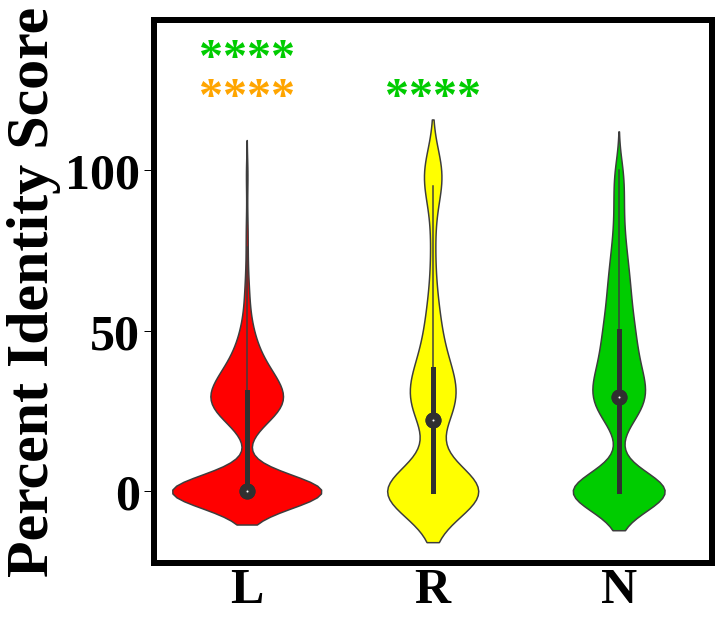

In [6]:
violin_plot("../generated-data/dataset_yeast_smf.feather", "redundancy-pident", 
            "Percent Identity Score", np.array(['L','R','N']))

# SMF vs GI

# pairs without smf: 1869
# observation in 0: 18015
# observation in 1: 6897562


/tmp/ipykernel_1153268/748890485.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, fontsize=plot_cfg['annot_size'])
/tmp/ipykernel_1153268/748890485.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(xlabels, fontsize=plot_cfg['annot_size'])


# observation in 2: 961
# observation in 3: 463


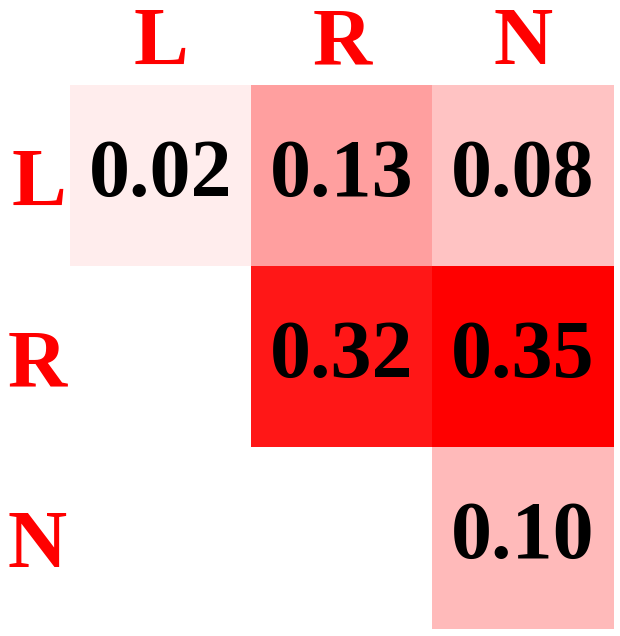

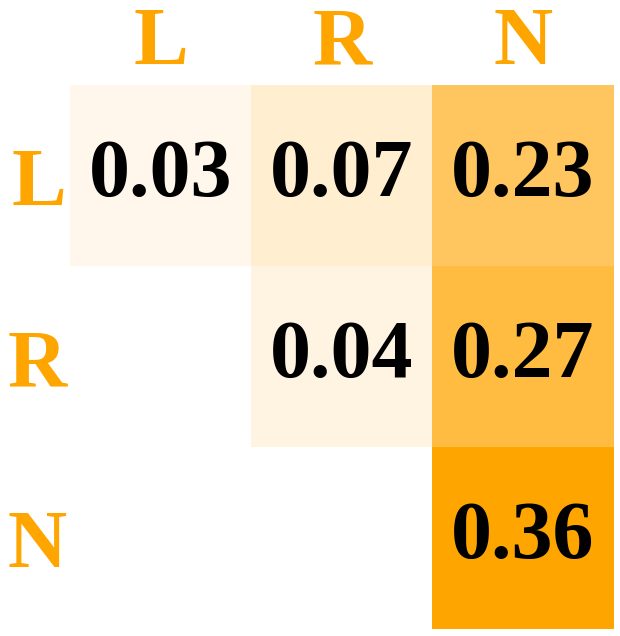

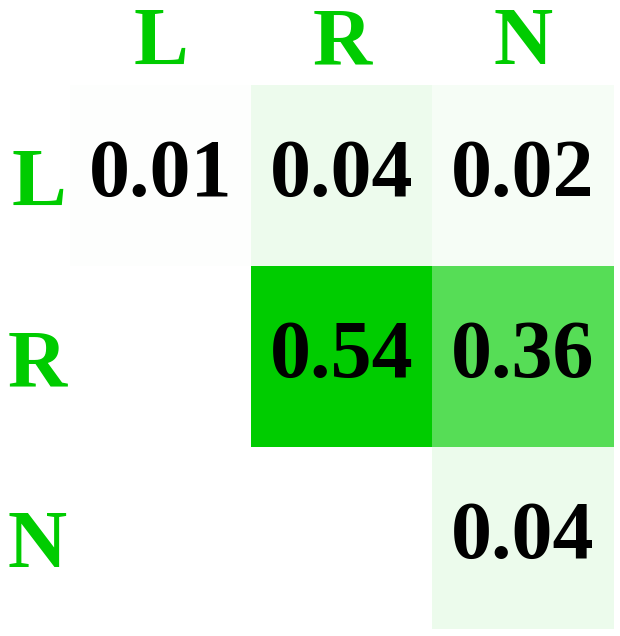

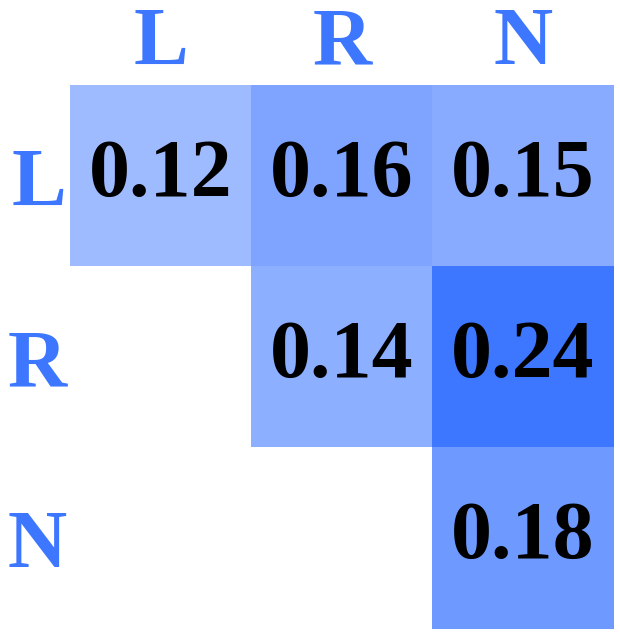

In [7]:
def smf_vs_gi(task_path, smf_task_path):
    labels = ['Negative', 'Neutral', 'Positive', 'Suppression']
    colors = ['#FF0000', 'orange', '#00CC00', '#3d77ff']

    smf_classes = ['L', 'R', 'N']

    plot_cfg = {
        "tick_label_size" : 50,
        "xlabel_size" : 60,
        "ylabel_size" : 60,
        "border_size" : 6,
        "bar_border_size" : 2.5,
        "bar_label_size" : 48,
        "stars_label_size" : 48,
        "annot_size" : 82
    }
    
    df = pd.read_feather(task_path)
    smf_df = pd.read_feather(smf_task_path)
    
    smf = dict(zip(smf_df['id'], smf_df['bin']))
    
    genes_with_smf = set(smf_df['id'])

    with_smf_ix = (df['a_id'].isin(genes_with_smf)) & (df['b_id'].isin(genes_with_smf))
    print("# pairs without smf: %d" % np.sum(~with_smf_ix))

    for bin in range(len(labels)):
        ix = (df['bin'] == bin) & with_smf_ix
        print("# observation in %d: %d" % (bin, np.sum(ix)))

        sdf = df[ix]

        a_smf_bin = np.array([smf[i] for i in sdf['a_id']]).astype(int)
        b_smf_bin = np.array([smf[i] for i in sdf['b_id']]).astype(int)
        
        M = np.zeros((3, 3))
        for i in range(len(a_smf_bin)):
            abin = a_smf_bin[i]
            bbin = b_smf_bin[i]
            
            abin, bbin = sorted((abin,bbin))
            
            M[abin, bbin] += 1
        
        Mnormed = M / np.sum(M)


        f, ax = plt.subplots(figsize=(10, 10))

        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",["white",colors[bin]])

        ax.imshow(Mnormed, cmap=cmap)
        for i in range(M.shape[0]):
            for j in range(i,M.shape[0]):
                ax.text(j, i, "%0.2f" % Mnormed[i, j], ha="center", va="center", 
                fontsize=plot_cfg['annot_size'])

        xlabels = ax.get_xticks()
        ix = np.isin(xlabels, np.arange(Mnormed.shape[0]))
        xlabels = xlabels.astype(str)
        xlabels[ix] = smf_classes
        xlabels[~ix] = ''

        ax.set_xticklabels(xlabels, fontsize=plot_cfg['annot_size'])
        ax.set_yticklabels(xlabels, fontsize=plot_cfg['annot_size'])
        
        ax.xaxis.set_tick_params(length=0, width=0, which='both', colors=colors[bin])
        ax.yaxis.set_tick_params(length=0, width=0, which='both', colors=colors[bin])
        ax.xaxis.tick_top()
        plt.setp(ax.spines.values(), linewidth=0)

#         plt.savefig("%s_%s.png" % (output_path, labels[bin]), bbox_inches='tight', dpi=100)


#         plt.close()
#         #plt.show()
    
smf_vs_gi("../generated-data/dataset_yeast_gi_hybrid.feather", "../generated-data/dataset_yeast_smf.feather")

# Shortest Path Length vs GI

2.82728566948071
Comparisons: 6, adjusted alpha: 0.008333
0 (3.00) vs. 1 (3.00): 0.000000 [3594.591598] (lens: 19638 vs 6897562)
0 (3.00) vs. 2 (3.00): 0.548784 [0.359501] (lens: 19638 vs 1024)
0 (3.00) vs. 3 (2.00): 0.000000 [455.832758] (lens: 19638 vs 646)
1 (3.00) vs. 2 (3.00): 0.000000 [143.953159] (lens: 6897562 vs 1024)
1 (3.00) vs. 3 (2.00): 0.000000 [922.668209] (lens: 6897562 vs 646)
2 (3.00) vs. 3 (2.00): 0.000000 [235.083692] (lens: 1024 vs 646)


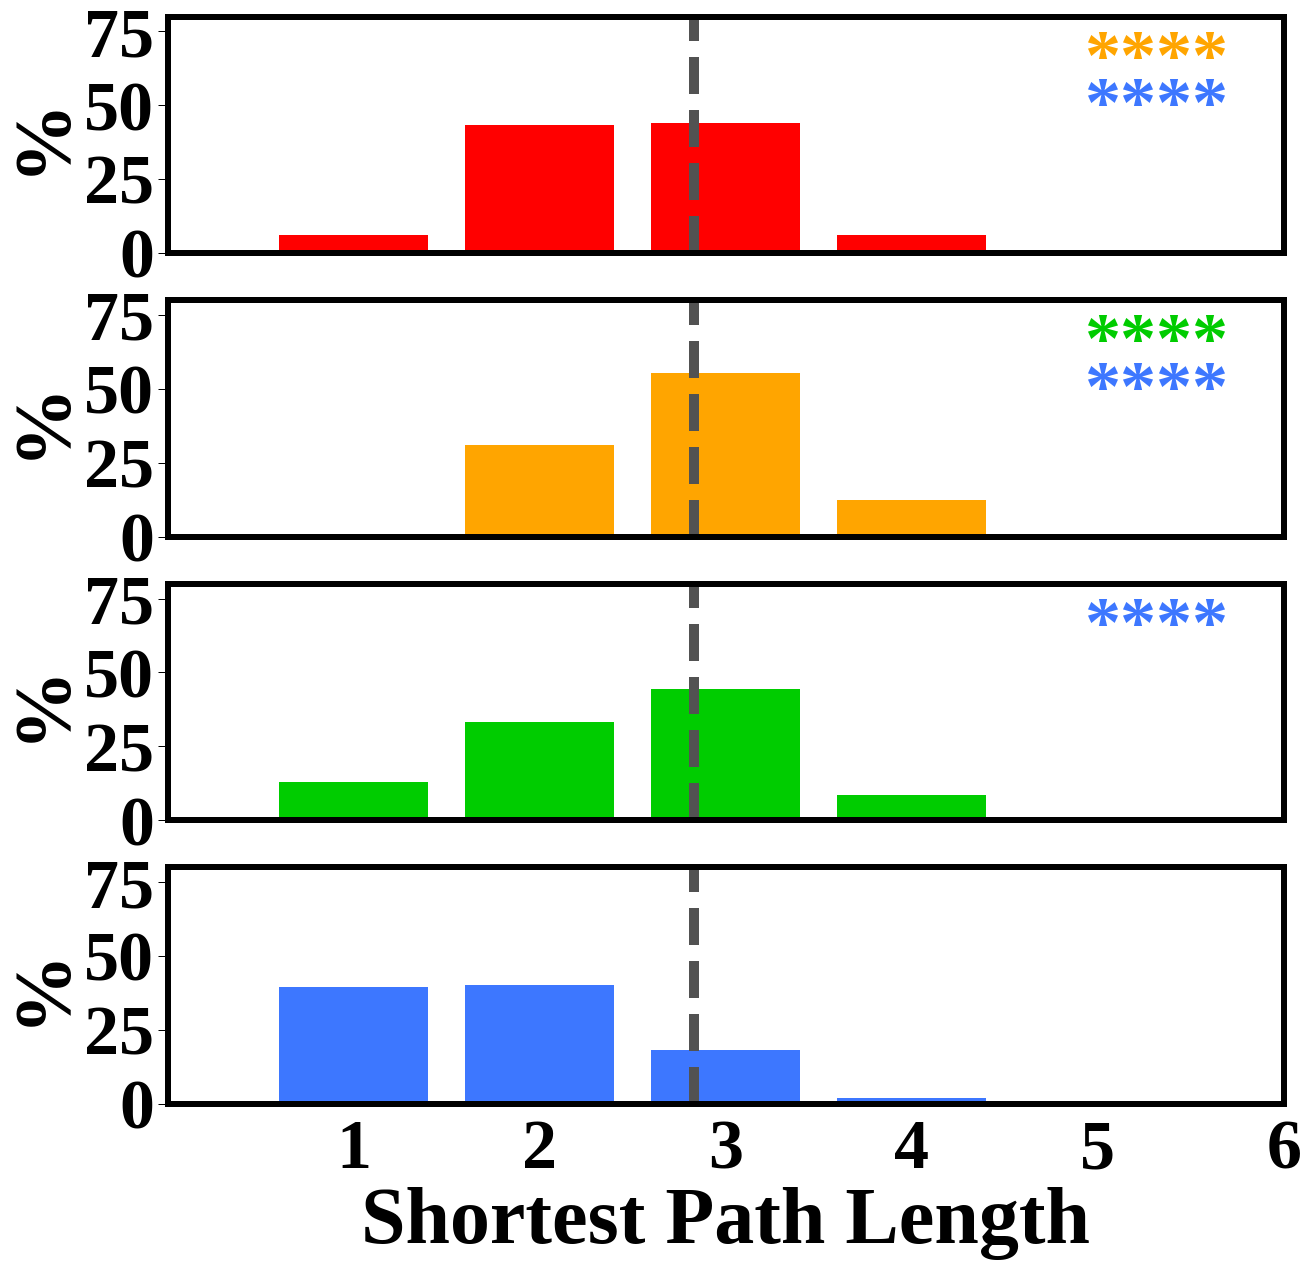

In [8]:
def spl_vs_gi(task_path, alpha=0.05):
    
    plot_cfg = {
        "tick_label_size" : 70,
        "xlabel_size" : 80,
        "ylabel_size" : 80,
        "border_size" : 6,
        "bar_border_size" : 2.5,
        "bar_label_size" : 48,
        "stars_label_size" : 72,
        "annot_size" : 82,
    }

    
    colors = ['#FF0000', 'orange', '#00CC00', '#3d77ff']
    star_colors = ['#FF0000', 'orange', '#00CC00', '#3d77ff'] 
    
    df = pd.read_feather(task_path)
    
    mean_spl = np.mean(df['pairwise-spl'])
    print(mean_spl)
    bins = sorted(np.unique(df['bin']))
    
    vals = df['pairwise-spl']

    val_range = np.arange(np.min(vals), np.max(vals)+1)

    M = np.zeros((len(bins), len(val_range)))
    for i in range(len(bins)):
        
        ix = df['bin'] == i
        sdf = df[ix]
        svals = vals[ix]
        
        freqs = []
        for v in val_range:
            freqs.append(np.sum(svals == v))
        
        M[i, :] = freqs 

    # normalize by row
    M = M * 100 / np.sum(M, axis=1, keepdims=True)
    max_val = 80

    fig, axes = plt.subplots(len(bins), 1, figsize=(20, 20), sharex=True)
    for i in range(len(bins)):
        
        axes[i].plot([mean_spl, mean_spl], [0, 100], linewidth=10, color='#525252', linestyle='--')

        axes[i].bar(val_range, M[i, :], color=colors[i])
        axes[i].yaxis.set_tick_params(labelsize=plot_cfg['tick_label_size'])
        axes[i].xaxis.set_tick_params(labelsize=plot_cfg['tick_label_size'])
        axes[i].set_xticks(val_range)
        axes[i].set_yticks([0, 25, 50, 75])
        axes[i].set_ylabel('%', fontsize=plot_cfg['ylabel_size'], weight='bold')
        axes[i].yaxis.set_tick_params(length=10, width=1, which='both')
        axes[i].xaxis.set_tick_params(length=0, pad=15)
        if i == len(bins) - 1:
            axes[i].set_xlabel("Shortest Path Length", fontsize=plot_cfg['xlabel_size'], weight='bold')
        axes[i].set_ylim([0, max_val])
        axes[i].set_xlim([0, 6])
        plt.setp(axes[i].spines.values(),linewidth=plot_cfg["border_size"], color='black')
    
    # plot pvalues
    num_comparisons = len(bins) * (len(bins)-1) / 2
    adjusted_alpha = alpha / num_comparisons
    print("Comparisons: %d, adjusted alpha: %f" % (num_comparisons, adjusted_alpha))
    
    for i in range(len(bins)):
        ix = df['bin'] == i
        a = vals[ix]

        a_med = np.median(a)
        yoffset = 0.95
        xoffset = 0.95
        for j in range(i+1, len(bins)):
            ix = df['bin'] == j
            b= vals[ix]

            statistic, pvalue = scipy.stats.kruskal(a, b)
            print("%s (%0.2f) vs. %s (%0.2f): %0.6f [%0.6f] (lens: %d vs %d)" % (bins[i], 
                np.median(a), bins[j], np.median(b), pvalue, statistic, a.shape[0], b.shape[0]))
            
            if pvalue < adjusted_alpha:
                stars = '*' * compute_stars(pvalue, adjusted_alpha)
                target_color = star_colors[j]
                axes[i].text(xoffset, yoffset, stars, 
                    transform=axes[i].transAxes,
                    color=target_color, ha="right", va="top", weight='bold', 
                    fontsize=plot_cfg['stars_label_size'])
                yoffset -= 0.2
                
spl_vs_gi('../generated-data/dataset_yeast_gi_hybrid.feather')

# Violin Plot: Sum LID vs GI

Comparisons: 6, adjusted alpha: 0.008333
- (6.35) vs. N (4.73): 0.000000 [3401.424706] (lens 19638 vs 6897562)
- (6.35) vs. + (6.15): 0.009510 [6.724452] (lens 19638 vs 1024)
- (6.35) vs. S (5.86): 0.009082 [6.806563] (lens 19638 vs 646)
N (4.73) vs. + (6.15): 0.000000 [103.749185] (lens 6897562 vs 1024)
N (4.73) vs. S (5.86): 0.000000 [75.356815] (lens 6897562 vs 646)
+ (6.15) vs. S (5.86): 0.789954 [0.070953] (lens 1024 vs 646)


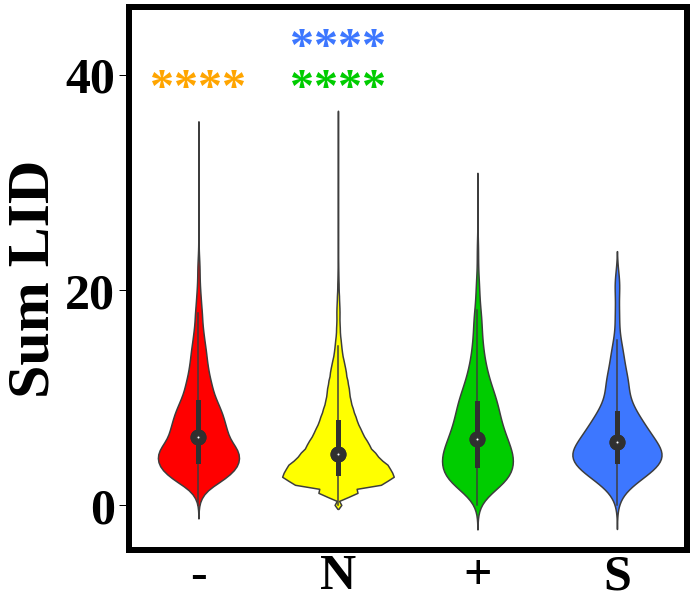

In [9]:
violin_plot("../generated-data/dataset_yeast_gi_hybrid_mn.feather", "topology-lid", "Sum LID", bins=np.array(['-', 'N', '+', 'S']),
            colors=['#FF0000', '#FFFF00', '#00CC00', '#3d77ff'], star_colors=['#FF0000', 'orange', '#00CC00', '#3d77ff'])

# GO vs GI

In [10]:
def pairwise_sgo_matrix_orig(task_path, sg_path):
    df = pd.read_feather(task_path)
    sgdf = pd.read_feather(sg_path)
    
    sgo_cols = sgdf.columns[sgdf.columns.str.startswith('sgo-')]
    
    n_terms = len(sgo_cols)

    F = np.array(sgdf[sgo_cols])
    
    a_id = np.array(df['a_id'])
    b_id = np.array(df['b_id'])
    gibin = np.array(df['bin'])
    
    R = np.zeros((n_terms, n_terms, 4))

    for i in range(df.shape[0]):
        
        # get the terms of gene a
        a_terms = np.where(F[a_id[i], :])[0]
        
        # get the terms of gene b
        b_terms = np.where(F[b_id[i], :])[0]
        
        # create a set of all pairwise combinations
        pairs = set()
        for aid in a_terms:
            for bid in b_terms:
                pairs.add(tuple(sorted((aid, bid))))
        
        # for each combination, increment the relevant count
        # except if it is on the diagonal, to prevent double-counting
        for aid, bid in pairs:

            R[aid, bid, gibin[i]] += 1
            if bid != aid:
                R[bid, aid, gibin[i]] += 1
    
        # if i % 100000 == 0:
        #     print(i)
    
    return R, sgo_cols 

R_orig, sgo_cols = pairwise_sgo_matrix_orig("../generated-data/dataset_yeast_gi_hybrid.feather", "../generated-data/dataset_yeast_allppc.feather")

In [11]:
def compare_diagonal_to_off_diagonal(R, bin_labels):
    R_tot = np.sum(R, axis=2)

    # analyze the intensity of on diagonal vs off-diagonal terms
    for b in [0, 2, 3]:
        R_b = R[:, :, b] / R_tot

        off_diag_vals = np.triu(R_b, 1) + np.tril(R_b, -1)
        
        diag_vals = np.diagonal(R_b)[:,np.newaxis]
        u = np.mean(off_diag_vals, axis=1, keepdims=True)
        statistic, pvalue = scipy.stats.ttest_rel(diag_vals, u)
        print("[%s] statistic=%f, pvalue=%f" % (bin_labels[b], statistic, pvalue))
        print(" Mean on-diagonal: %f, mean average off-diagonal: %f" % (np.mean(diag_vals), np.mean(u)))
        
compare_diagonal_to_off_diagonal(R_orig, ['-','N','+','S'])

[-] statistic=4.093003, pvalue=0.000179
 Mean on-diagonal: 0.019001, mean average off-diagonal: 0.003909
[+] statistic=3.205714, pvalue=0.002510
 Mean on-diagonal: 0.001088, mean average off-diagonal: 0.000171
[S] statistic=5.104787, pvalue=0.000007
 Mean on-diagonal: 0.001359, mean average off-diagonal: 0.000151


Alpha = 1.1250, Beta=-2.1972
Min 0.000000 - Max 0.141991
Min 0.000000 - Max 0.010563
Min 0.000000 - Max 0.007923


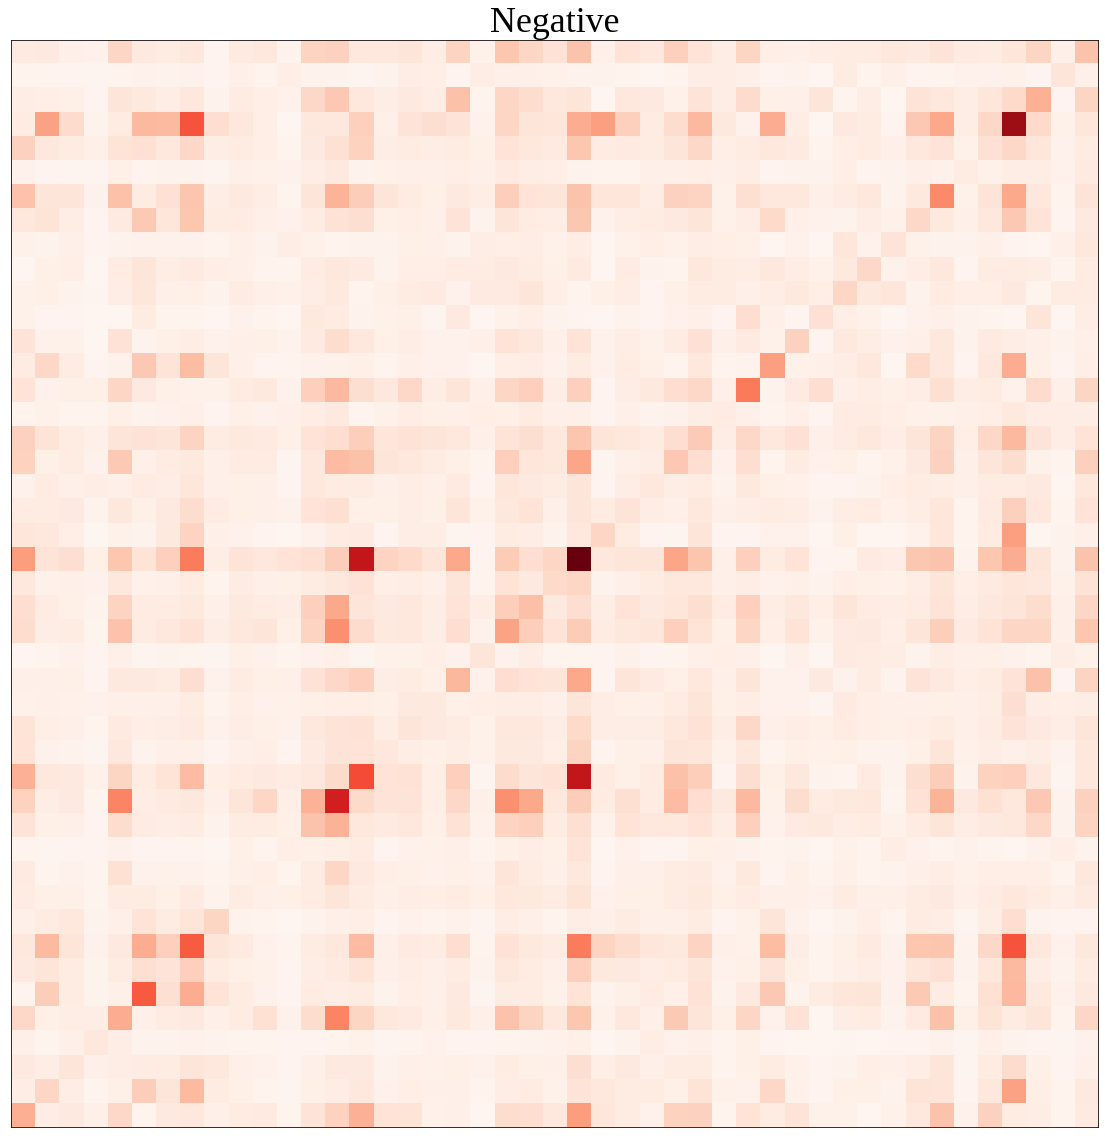

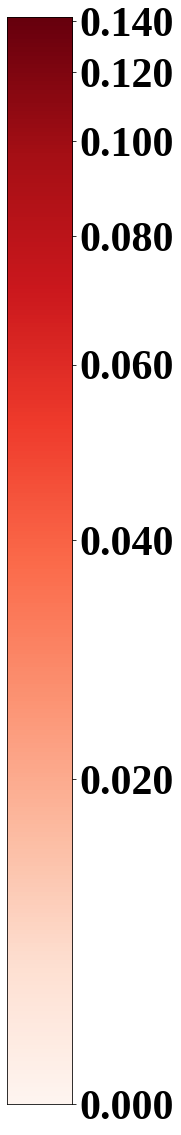

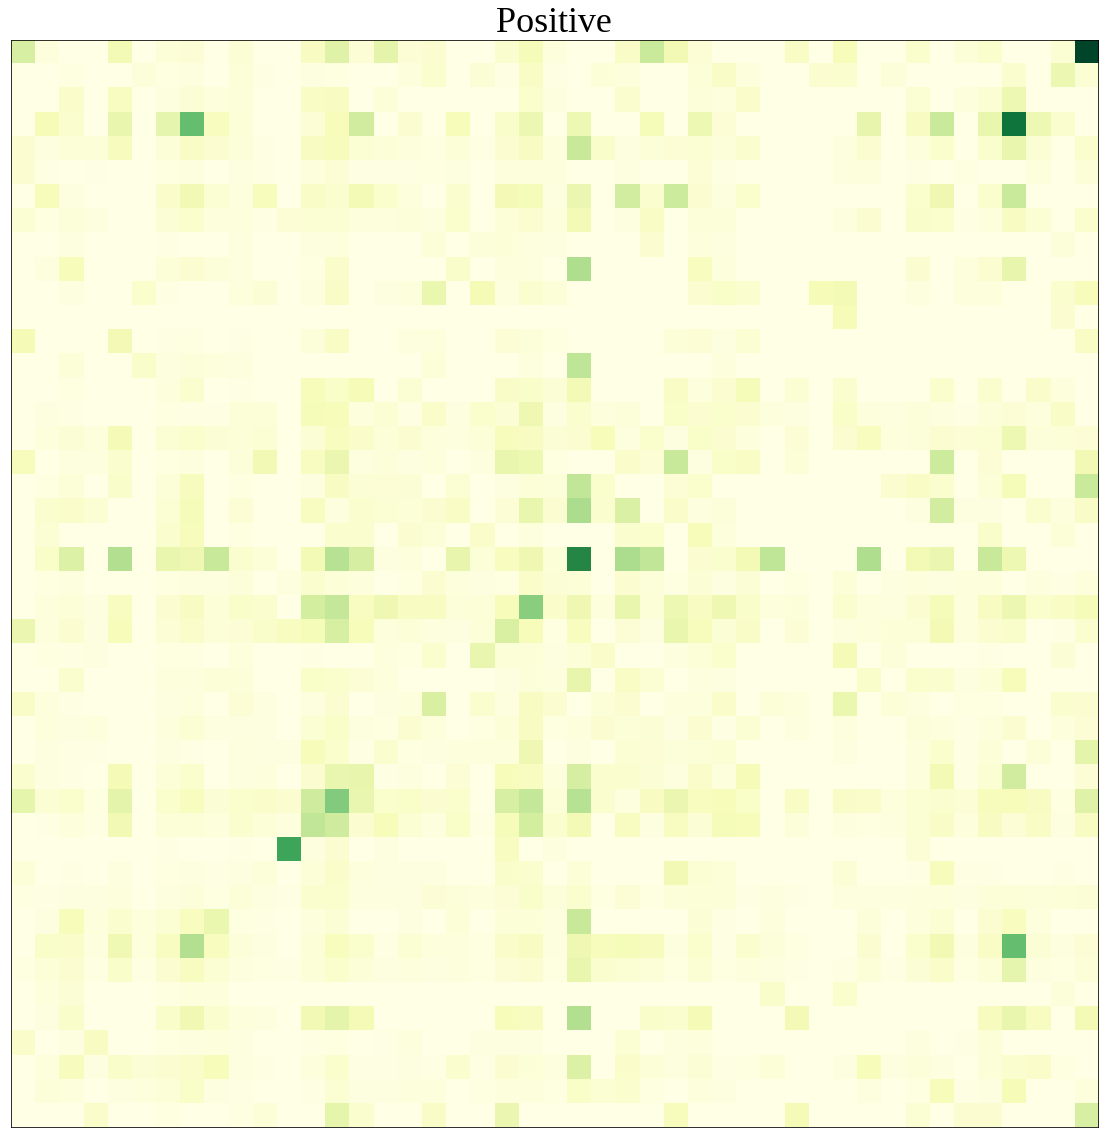

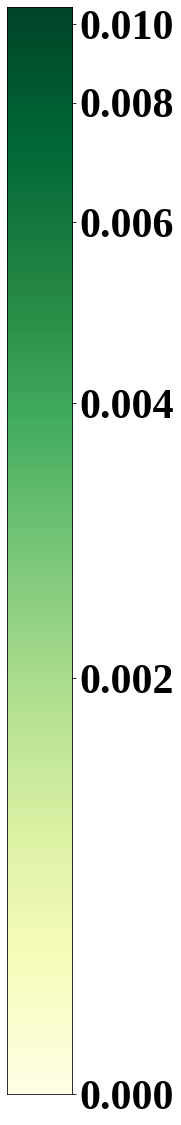

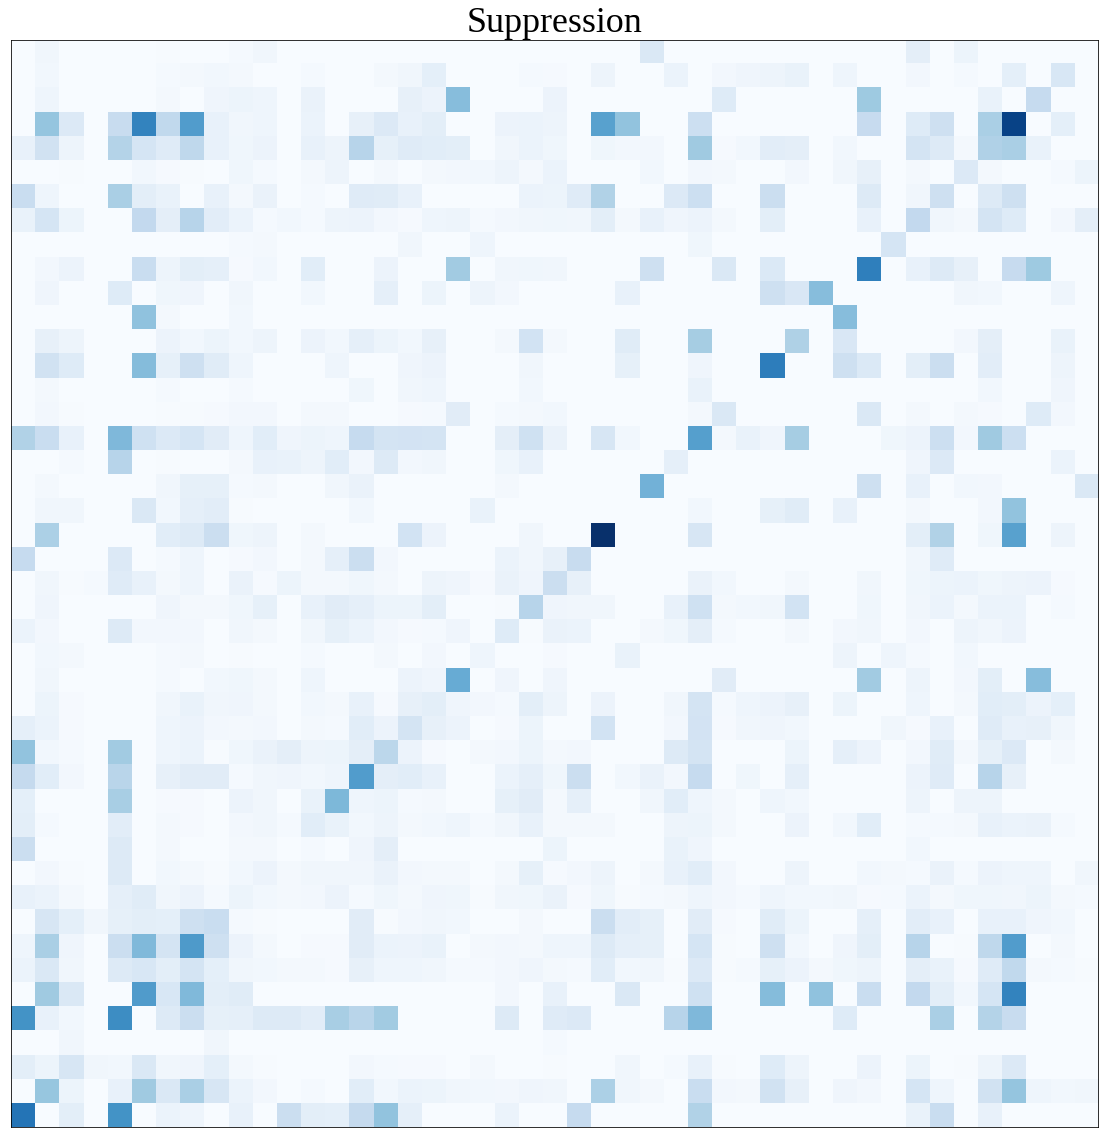

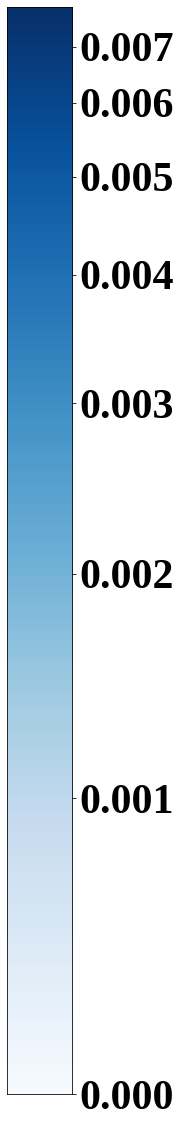

In [12]:
def create_go_matrix_transform(m, c):

    beta = -1
    for i in range(100):
        beta = np.log(1 - c + c * np.exp(beta)) / m 
    alpha = 1 / (1-np.exp(beta))

    print("Alpha = %0.4f, Beta=%0.4f" % (alpha,beta))
    def transform(A):

        A = alpha * (1 - np.exp(beta * A))
        return A 

    return transform

def create_labels(sgo_cols):
    with open('../generated-data/go_ids_to_names.json', 'r') as f:
        id_to_name = json.load(f)
        
    labels = [id_to_name[c.replace('sgo-','')] for c in sgo_cols]
    return labels
            
def plot_go_vs_gi(R, sgo_labels=[], with_labels=False, bin_labels=['Negative', 'Neutral', 'Positive', 'Suppression']):
    transform = create_go_matrix_transform(0.5, 0.75)
    font_size = 60
    locator = ticker.AutoLocator()
    
    R_tot = np.sum(R, axis=2)
    
    R = R.copy()
    for i, b in enumerate([0, 2, 3]):
        R_b = R[:, :, b]
        R_b /= R_tot
        R_b[R_tot == 0] = 0
        R[:,:,b] = R_b 
    
    cmaps = ['Reds', '', 'YlGn', 'Blues']

    for i, b in enumerate([0, 2, 3]):
        
        R_b = R[:,:,b]
        
        min_R_b, max_R_b = np.min(R_b), np.max(R_b)
        R_b = (R_b - min_R_b) / (max_R_b - min_R_b)
        R_b = transform(R_b)

        cmap = cmaps[b]
        
        if with_labels:
            figsize = (50,50)
        else:
            figsize = (20, 20)
        f, ax = plt.subplots(1, 1, figsize=figsize)
        r = ax.imshow(R_b, origin='lower', cmap=cmap, vmin=0, vmax=1)
        ax.set_title(bin_labels[b], fontsize=36)

        if with_labels:
            
        
            ax.set_xticks(np.arange(R.shape[0]))
            ax.set_yticks(np.arange(R.shape[0]))
            ax.tick_params(axis='x', rotation=90)
            ax.set_xticklabels(sgo_labels, fontdict={ "fontsize" : font_size, "weight": "bold" })
            ax.set_yticklabels(sgo_labels, fontdict={ "fontsize" : font_size, "weight": "bold" })
        else:
            ax.set_xticks([])
            ax.set_yticks([])
        
        # plotting the colorbar
        f, ax = plt.subplots(1, 1, figsize=(10, 20))
        xs = np.linspace(0, 1, 1000)
        ys = xs
        ax.imshow(ys[:,np.newaxis], aspect=1/60, cmap=cmap)

        print("Min %f - Max %f" % (min_R_b, max_R_b))
        xpos = locator.tick_values(min_R_b, max_R_b)
        
        xticks = transform((xpos - min_R_b) / (max_R_b - min_R_b))  * 1000
        ax.set_yticks(xticks)
        
        ax.set_yticklabels(['%0.3f' % e for e in xpos], fontsize=42, fontweight='bold')
        ax.set_ylim([0, 1000])
        ax.yaxis.tick_right()
        ax.set_xticks([])
        
#         output_path = "../tmp/go_term_enrichment_%s_%s.png" % (BIN_LABELS[bin], 'labels' if WITH_LABELS else 'nonlabels') 
#         plt.savefig(output_path, bbox_inches='tight', dpi=DPI, quality=100)
plot_go_vs_gi(R_orig, create_labels(sgo_cols), False)      

# Complex and Pathway Interactions vs GI

[0] 198 198
[1] 198 198
[2] 198 198
[3] 198 198
[0] 36 36
[1] 36 36
[2] 36 36
[3] 36 36


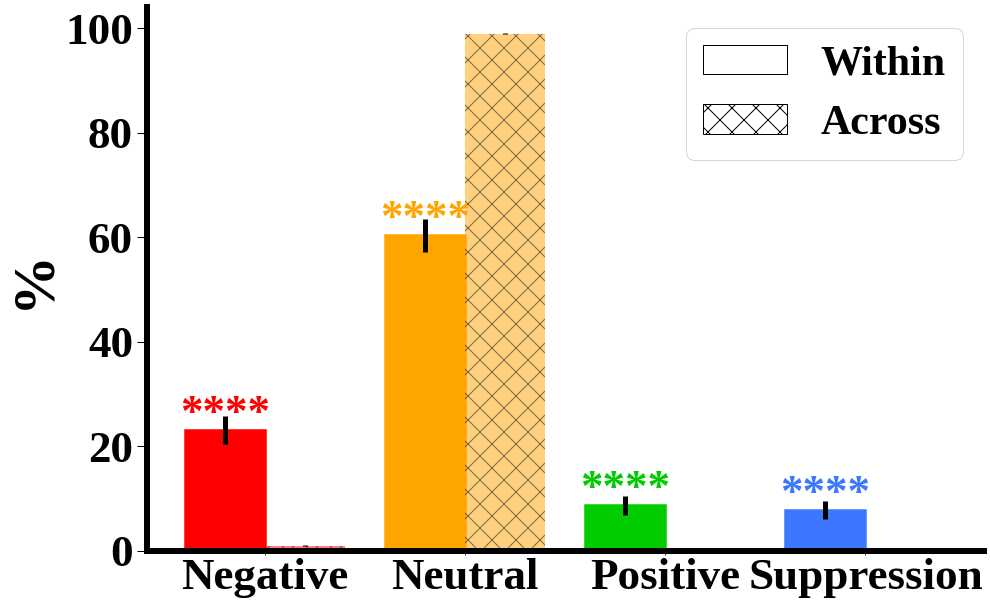

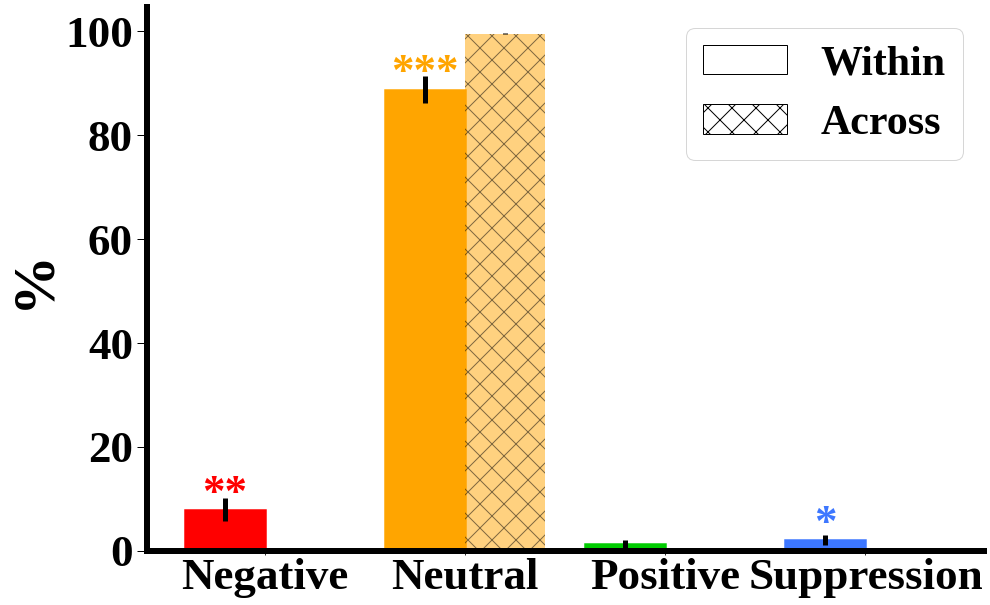

In [13]:
def summarize_groups(group_analysis_path, bin_labels=['Negative', 'Neutral', 'Positive', 'Suppression']):
    col_names = ['no. neg', 'no. neut', 'no. pos', 'no. sup']

    df = pd.read_excel(group_analysis_path, sheet_name='normalized', header=8)

    df = df[~np.isnan(df['size'])]
    rows = []
    for i, r in df.iterrows():
        for bin in range(len(bin_labels)):
            col_name = col_names[bin]
            rows.append({
                "bin" : bin_labels[bin],
                "prop" : 'within',
                "bin_id" : bin,
                "count" : r[col_name + ' within'] * 100
            })
            rows.append({
                "bin" : bin_labels[bin],
                "prop" : 'across',
                "bin_id" : bin,
                "count" : r[col_name + ' across'] * 100
            })
    sdf = pd.DataFrame(rows)
    return sdf 

def plot_groups_summary(sdf, colors=['#FF0000', 'orange', '#00CC00', '#3d77ff'], figsize=(15,10), alpha=0.05):
    plot_cfg = {
        "tick_label_size" : 45,
        "xlabel_size" : 50,
        "ylabel_size" : 60,
        "border_size" : 6,
        "bar_border_size" : 2.5,
        "bar_label_size" : 48,
        "stars_label_size" : 45,
        "annot_size" : 82,
        "legend_label_size" : 42
    }
    
    f, ax = plt.subplots(1, 1, figsize=figsize)

    bin_ids = np.unique(sdf['bin_id'])
    
    bar = sns.barplot(x="bin", 
        y="count", 
        hue="prop",
        data=sdf, 
        ci=None,
        edgecolor='black',
        errwidth=5,
        errcolor='black',
        linewidth=plot_cfg["bar_border_size"],
        saturation=1)
    ax.legend().remove()

    across_patch = mpatches.Patch(facecolor='white', fill=False, hatch='x',label='Across')
    within_patch = mpatches.Patch(facecolor='white', edgecolor='black', fill=True, label='Within')
    ax.legend(handles=[within_patch, across_patch], fontsize=plot_cfg['legend_label_size'])
    ylim = ax.get_ylim()
    for i, b in enumerate(bar.patches):
        
        # get the hue of that bar
        hid = i // len(bin_ids)
        gid = i % len(bin_ids)

        group = bin_ids[gid]
        
        x,y = b.get_xy()
        height = b.get_height()
        width = b.get_width()
        
        bin_df = sdf[sdf['bin_id'] == group]
        within_counts = bin_df[bin_df['prop'] == 'within']['count']
        across_counts = bin_df[bin_df['prop'] == 'across']['count']
            
        if hid > 0:
            b.set_hatch('x')
            b.set_linewidth(0)
            b.set_facecolor(colors[group])
            b.set_alpha(0.5)
            
            mu = np.mean(across_counts)
            std = np.std(across_counts, ddof=1) / np.sqrt(len(across_counts))

        else:
            
            mu = np.mean(within_counts)
            std = np.std(within_counts, ddof=1) / np.sqrt(len(within_counts))


            print("[%s] %d %d" % (group, within_counts.shape[0], across_counts.shape[0]))
            statistic, pvalue = scipy.stats.ttest_rel(within_counts, across_counts)
            stars = '*' * compute_stars(pvalue, alpha)
            
            offset = ylim[1] / 15.0
            ax.text(x + width/2, 
                y + height + offset, stars, 
                color=colors[group], 
                ha="center", 
                va="top", 
                weight='bold', 
                fontsize=plot_cfg['stars_label_size'])

            b.set_color(colors[group])
        
        ax.errorbar([x+width/2], [mu], yerr=std, linewidth=5, color='black')
            
    ax.yaxis.set_tick_params(labelsize=plot_cfg['tick_label_size'])
    ax.xaxis.set_tick_params(labelsize=plot_cfg['tick_label_size'])
    ax.set_ylabel("%", fontsize=plot_cfg['ylabel_size'], fontweight='bold')
    ax.set_xlabel("")
    ax.yaxis.set_tick_params(length=10, width=1, which='both')

    plt.setp(ax.spines.values(), linewidth=plot_cfg['border_size'], color='black')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plot_groups_summary(summarize_groups("../generated-data/complexes_analysis.xlsx"))
plot_groups_summary(summarize_groups("../generated-data/pathways_analysis.xlsx"))

# Triple GI Analyses

In [14]:
def chi2(f_obs):

    # compute expected frequencies
    col_marginal = np.sum(f_obs, axis=1, keepdims=True)
    row_marginal = np.sum(f_obs, axis=0, keepdims=True)
    total = np.sum(row_marginal)
    f_exp = np.dot(col_marginal / total, row_marginal)
    
    chisq, p = scipy.stats.chisquare(f_obs, f_exp, axis=None)
    
    ddof = (f_obs.shape[0]-1) * (f_obs.shape[1]-1)

    return chisq, p, ddof

def plot_distrib(df, pallete, xlabel, ylabel, max_x_categories, ylim, stars_color, xlim=None, legend_pos=(1, 1.05), stars_pos=(0.53, 0.98), tick_label_size=50):
    plot_cfg = {
        "tick_label_size" : tick_label_size,
        "xlabel_size" : 60,
        "ylabel_size" : 60,
        "border_size" : 6,
        "bar_border_size" : 2.5,
        "bar_label_size" : 32,
        "stars_label_size" : 48,
        "annot_size" : 72,
        "max_cm_classes" : 4,
        "legend_size" : 42,
        "max_bars" : 4
    }
    
    distinct_xs = set(df['x'])
    distinct_hues = set(df['hue'])

    dummy_rows = []

    if max_x_categories > 0:
        for i in range(max_x_categories - len(distinct_xs)):
            for hue in distinct_hues:
                dummy_rows.append({
                    "x" : " " * (i+1),
                    "y" : 0,
                    "hue" : hue
                })
    final_df = pd.concat((df, pd.DataFrame(dummy_rows)))

    f, ax = plt.subplots(1, 1, figsize=(15, 10))
    g = sns.barplot(x="x", 
                    y="y", 
                    hue="hue",
                    ax=ax,
                    data=final_df, 
                    palette=pallete)
    ax.yaxis.set_tick_params(labelsize=plot_cfg['tick_label_size'])
    ax.xaxis.set_tick_params(labelsize=plot_cfg['tick_label_size'], pad=15)
    ax.set_ylabel(ylabel, fontsize=plot_cfg['ylabel_size'], fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=plot_cfg['xlabel_size'], fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.setp(ax.spines.values(),linewidth=plot_cfg["border_size"], color='black')
    if ylim != None:
        ax.set_ylim(ylim)
    if xlim != None:
        ax.set_xlim(xlim)

    # construct R
    xs = list(distinct_xs)
    hues = list(distinct_hues)
    R = np.zeros((len(xs), len(hues)))
    for i in range(len(xs)):
        for j in range(len(hues)):
            R[i, j] = df[(df['x'] == xs[i]) & (df['hue'] == hues[j])]['raw_y']
            
    # perform Chi Sq test on R
    chisq, p, ddof = chi2(R)
    stars = '*' * compute_stars(p, 0.05)
    ax.legend(frameon=False, fontsize=plot_cfg['legend_size'], loc='upper right', bbox_to_anchor=legend_pos, ncol=1)
    ax.text(stars_pos[0], stars_pos[1], '****', 
        transform=ax.transAxes,
        color=stars_color, 
        ha="center", 
        va="top",
        weight='bold', 
        fontsize=plot_cfg['stars_label_size'])

## SMF vs Triple GI

# pairs without smf: 3635
# observation in 0: 2612
# observation in 1: 68216


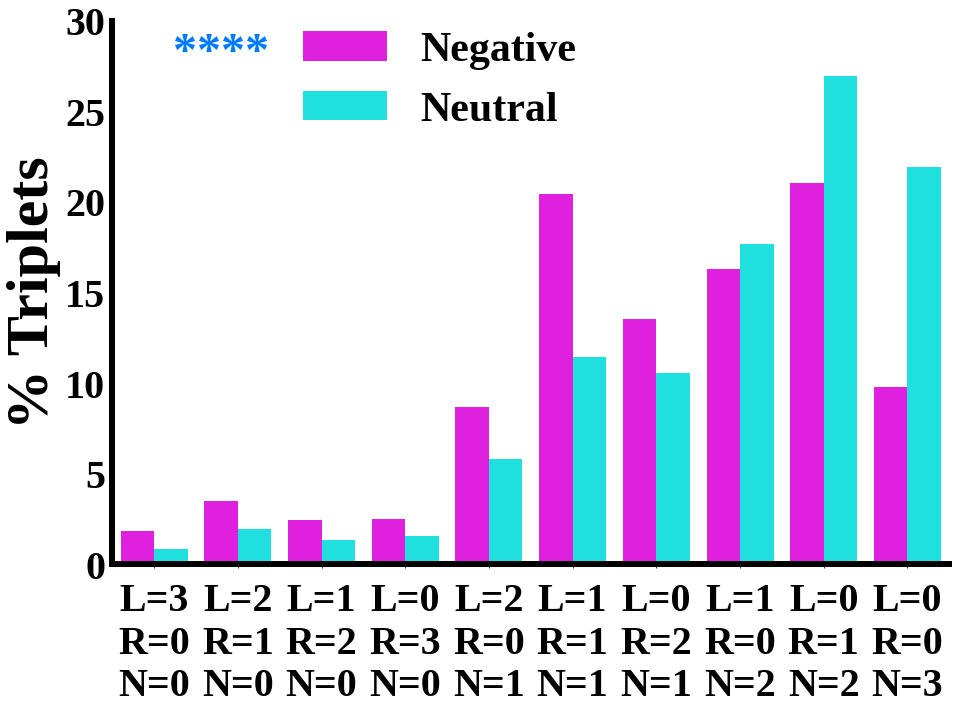

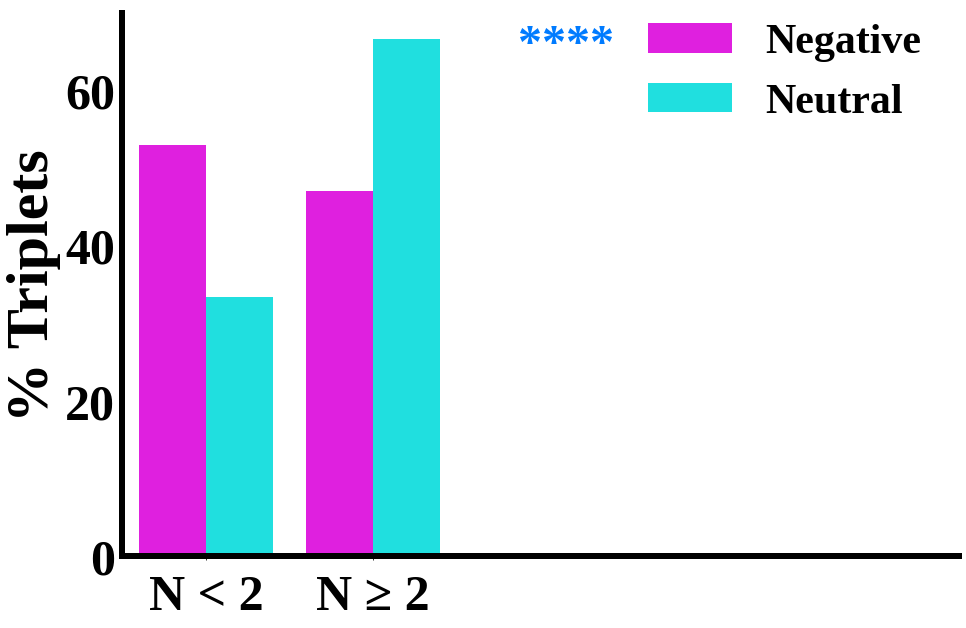

In [20]:
def compute_obs_freq(task_path, smf_path):
    
    df = pd.read_feather(task_path)
    
    smf_df = pd.read_feather(smf_path)
    
    smf = dict(zip(smf_df['id'], smf_df['bin']))
    
    genes_with_smf = set(smf_df['id'])

    with_smf_ix = (df['a_id'].isin(genes_with_smf)) & (df['b_id'].isin(genes_with_smf)) & (df['c_id'].isin(genes_with_smf))
    print("# pairs without smf: %d" % np.sum(~with_smf_ix))

    df = df[with_smf_ix]
    
    Ms = []
    for bin in range(2):
        ix = df['bin'] == bin
        print("# observation in %d: %d" % (bin, np.sum(ix)))

        sdf = df[ix]

        a_smf_bin = np.array([smf[i] for i in sdf['a_id']]).astype(int)
        b_smf_bin = np.array([smf[i] for i in sdf['b_id']]).astype(int)
        c_smf_bin = np.array([smf[i] for i in sdf['c_id']]).astype(int)
        
        all_bins = np.vstack((a_smf_bin, b_smf_bin, c_smf_bin)).T
        
        n_l = np.sum(all_bins == 0, axis=1)
        n_r = np.sum(all_bins == 1, axis=1)
        n_n = np.sum(all_bins == 2, axis=1)

        M = np.zeros((4,4,4))
        for i in range(len(a_smf_bin)):
            M[n_l[i], n_r[i], n_n[i]] += 1
        Ms.append(M)
    
    return Ms 

def create_tgi_detailed_smf(Ms, gi_labels=['Negative', 'Neutral']):
    rows = []
    for bin in [0, 1]:
        M = Ms[bin]
        
        vals = []
        labels = []
        for n_n in range(M.shape[0]):
            for n_r in range(4 - n_n):
                n_l = 3 - n_n - n_r
                vals.append(M[n_l, n_r, n_n])
                rows.append({
                    "x" : "L=%d\nR=%d\nN=%d" % (n_l, n_r, n_n),
                    "hue" : gi_labels[bin], 
                    "y" : M[n_l, n_r, n_n] * 100 / np.sum(M),
                    "raw_y" : M[n_l, n_r, n_n]
                })
        
    return pd.DataFrame(rows)
    
def create_tgi_summary_smf(Ms, gi_labels=['Negative', 'Neutral']):
    rows = []
    for bin in [0, 1]:
        M = Ms[bin]
        
        rows.append({
            "x" : "N < 2",
            "hue" : gi_labels[bin],
            "y" : np.sum(M[:, :, :2]) * 100 / np.sum(M),
            "raw_y" : np.sum(M[:, :, :2])
        })
        
        rows.append({
            "x" : "N ≥ 2",
            "hue" : gi_labels[bin],
            "y" : np.sum(M[:, :, 2:]) * 100 / np.sum(M),
            "raw_y" : np.sum(M[:,:,2:])
        })
        
    return pd.DataFrame(rows)

Ms = compute_obs_freq("../generated-data/dataset_yeast_tgi.feather", "../generated-data/dataset_yeast_smf.feather")
plot_distrib(create_tgi_detailed_smf(Ms), { 'Negative' : 'magenta', 'Neutral' : 'cyan' }, 
            '', '% Triplets', 0,
            [0, 30], '#007bff',
            legend_pos=(0.6, 1.05),
            stars_pos=(0.13, 0.98), tick_label_size=40)

plot_distrib(create_tgi_summary_smf(Ms), { 'Negative' : 'magenta', 'Neutral' : 'cyan' }, 
            '', '% Triplets', 0,
            [0, 70], '#007bff', tick_label_size=50, xlim=[-0.5, 4.5])

## Violin Plot: Sum LID vs Triple GI

Comparisons: 1, adjusted alpha: 0.050000
- (9.37) vs. N (7.95): 0.000000 [259.653389] (lens 2835 vs 71628)


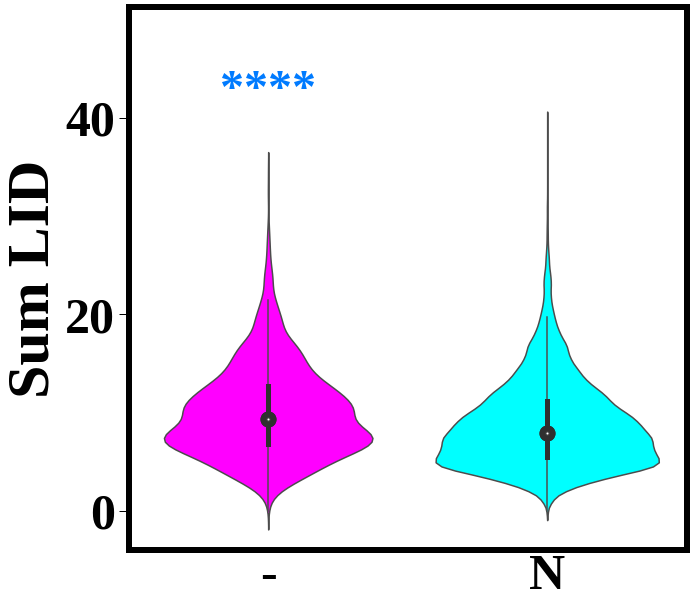

In [15]:
violin_plot("../generated-data/dataset_yeast_tgi_mn.feather", "topology-lid", "Sum LID", bins=np.array(['-', 'N']), 
            colors=['magenta','cyan'], star_colors=['magenta','#007bff'])

## Shortest Circuit Length vs Triple GI

# observation in 0: 2835
# observation in 1: 71628


/home/mmkhajah/Projects/cvp/cell_viability_paper/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:6766: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs_float - f_exp)**2 / f_exp


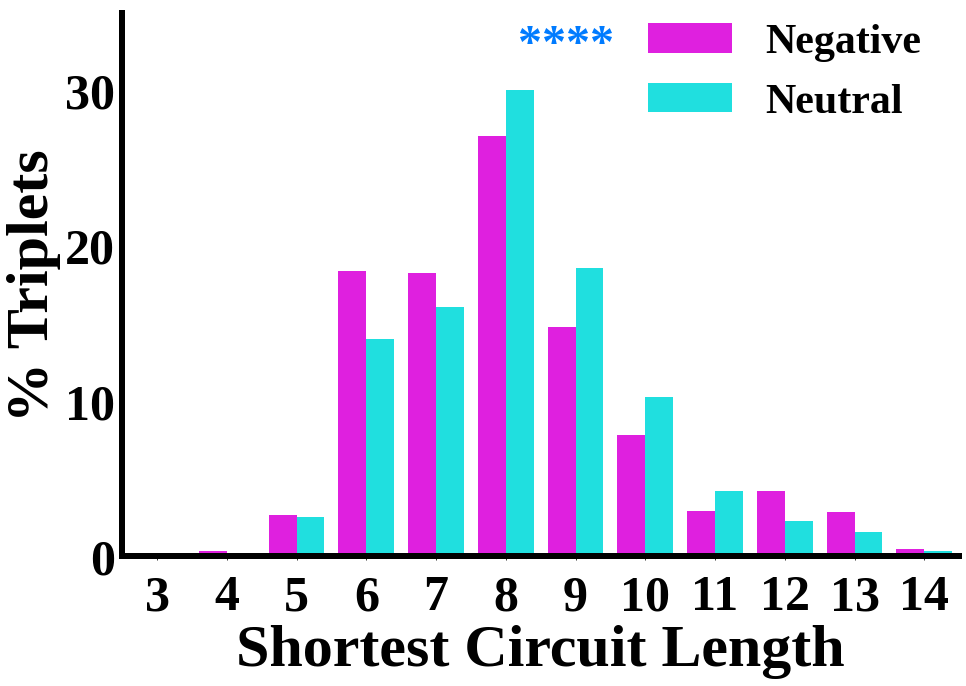

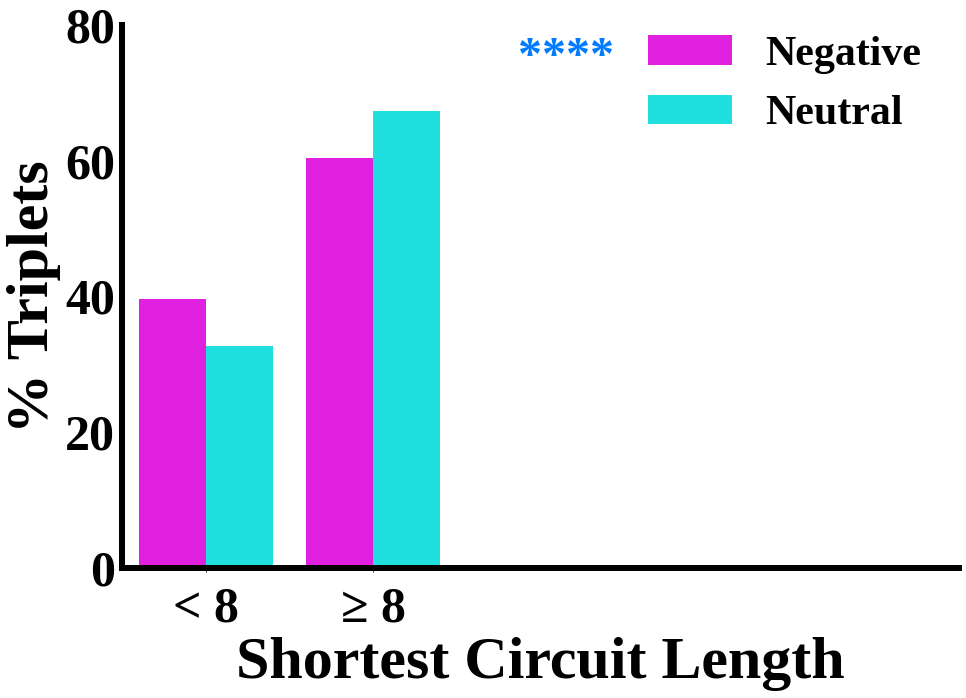

In [16]:
def compute_scl_freqs(task_path):
    
    df = pd.read_feather(task_path)
    
    scl = df['abc-pairwise-spl']
    
    max_scl = int(np.max(scl))
    
    Ms = np.zeros((2, max_scl+1))
    
    for bin in range(2):
        ix = df['bin'] == bin
        print("# observation in %d: %d" % (bin, np.sum(ix)))
        
        cnts = np.bincount(scl[ix])
        Ms[bin, :cnts.shape[0]] = cnts 
    
    return Ms 

def create_detailed_scl_df(scl_freqs, gi_labels=['Negative', 'Neutral']):
    rows = []
    for bin in [0, 1]:
        M = scl_freqs[bin]

        vals = []
        labels = []
        for i, val in enumerate(M):
            rows.append({
                "x" : "%d" % i,
                "hue" : gi_labels[bin],
                "y" : val * 100 / np.sum(M),
                "raw_y" : val
            })
        
    r = pd.DataFrame(rows)
    
    return r

def create_summary_scl_df(scl_freqs, thres, gi_labels=['Negative', 'Neutral']):
    rows = []
    for bin in [0, 1]:
        M = scl_freqs[bin]
        
        rows.append({
            "x" : "< %d" % thres,
            "hue" : gi_labels[bin],
            "y" : np.sum(M[:thres]) * 100 / np.sum(M),
            "raw_y" : np.sum(M[:thres])
        })
        
        rows.append({
            "x" : "≥ %d" % thres,
            "hue" : gi_labels[bin],
            "y" : np.sum(M[thres:]) * 100 / np.sum(M),
            "raw_y" : np.sum(M[thres:])
        })
        
    r = pd.DataFrame(rows)
    
    return r

scl_freqs = compute_scl_freqs("../generated-data/dataset_yeast_tgi_mn.feather")
plot_distrib(create_detailed_scl_df(scl_freqs), { 'Negative' : 'magenta', 'Neutral' : 'cyan' }, 
            'Shortest Circuit Length', '% Triplets', 0,
            [0, 35], '#007bff', tick_label_size=50, xlim=[2.5, 14.5])
plot_distrib(create_summary_scl_df(scl_freqs, 8), { 'Negative' : 'magenta', 'Neutral' : 'cyan' }, 
            'Shortest Circuit Length', '% Triplets', 0,
            [0, 80], '#007bff', tick_label_size=50, xlim=[-0.5, 4.5])

## Shared sGO terms vs Triple GI

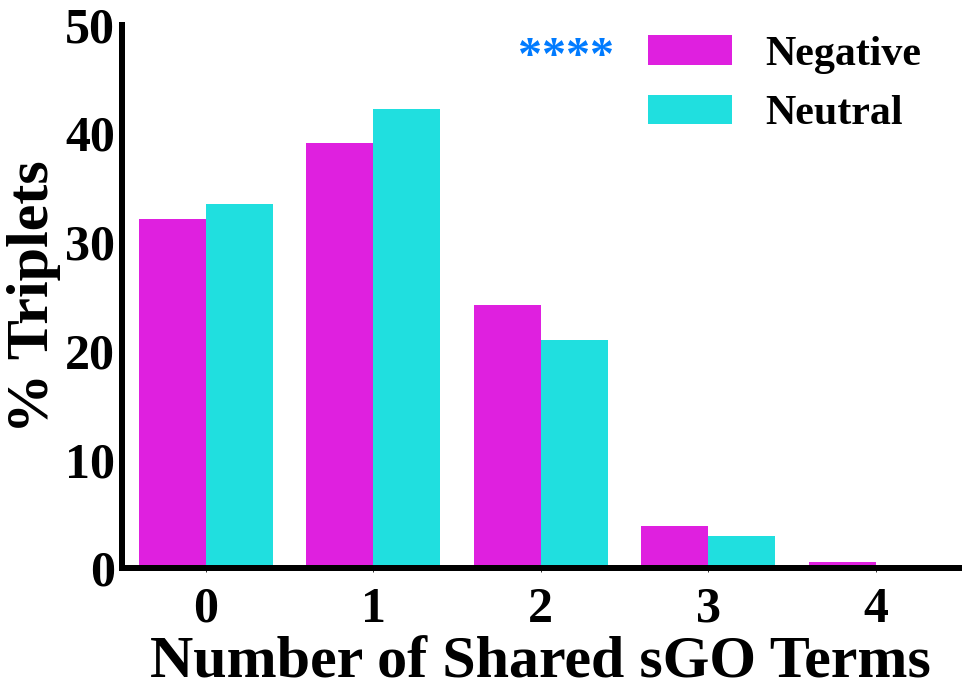

In [17]:
def compute_tgi_shared_sgo(task_path, thres):
    df = pd.read_feather(task_path)
    
    sum_sgo = np.array(df[ df.columns[df.columns.str.startswith('sgo-')] ])
    
    shared_terms = sum_sgo >= thres 
    
    sum_shared_terms = np.sum(shared_terms, axis=1)
    max_shared_terms = np.max(sum_shared_terms)
    
    neg_ix = df['bin'] == 0
    
    M = np.zeros((2, max_shared_terms+1))
    
    neg_shared_terms = np.bincount(sum_shared_terms[neg_ix])
    M[0, :neg_shared_terms.shape[0]] = neg_shared_terms
    
    net_shared_terms = np.bincount(sum_shared_terms[~neg_ix])
    M[1, :net_shared_terms.shape[0]] = net_shared_terms
    
    return M
def create_tgi_shared_sgo_df(shared_sgo_freqs, gi_labels=['Negative', 'Neutral']):
    rows = []
    for bin in [0, 1]:
        M = shared_sgo_freqs[bin,:]

        vals = []
        labels = []
        for i, val in enumerate(M):
            rows.append({
                "x" : "%d" % i,
                "hue" : gi_labels[bin],
                "y" : val * 100 / np.sum(M),
                "raw_y" : val
            })
        
    r = pd.DataFrame(rows)
    
    return r

plot_distrib(create_tgi_shared_sgo_df(compute_tgi_shared_sgo("../generated-data/dataset_yeast_tgi_mn.feather", 2)), 
             { 'Negative' : 'magenta', 'Neutral' : 'cyan' }, 
             'Number of Shared sGO Terms', '% Triplets', 0,
             [0, 50], '#007bff', tick_label_size=50, xlim=[-0.5, 4.5])


## Complex Interactions vs Triple GI

        x       hue          y  raw_y
0  Across  Negative   6.378164    451
1  Across   Neutral  93.621836   6620
2  Within  Negative  28.571429      2
3  Within   Neutral  71.428571      5


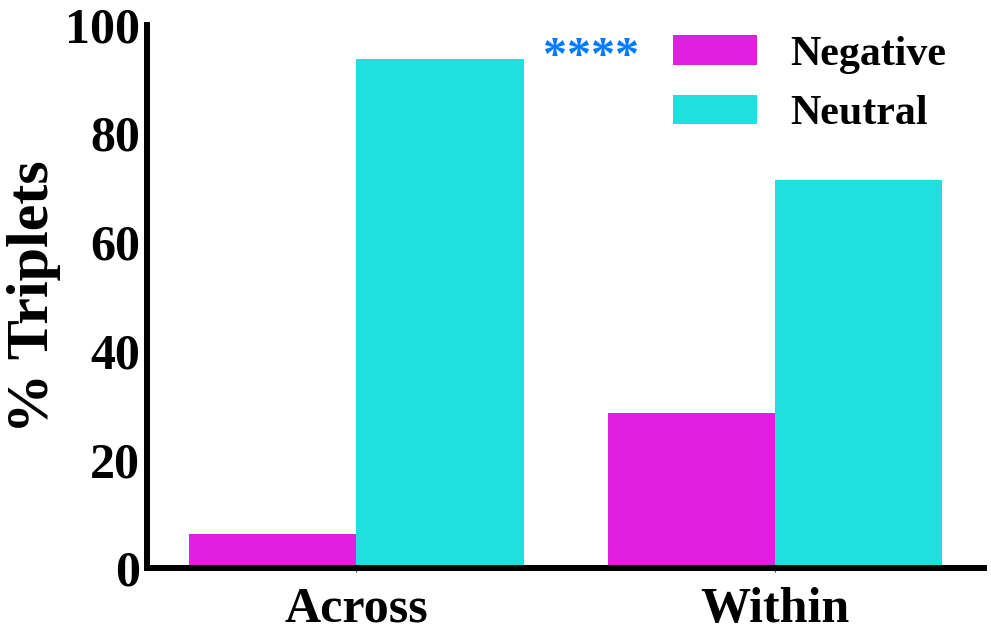

In [18]:
def compute_tgi_complex_interactions(task_path):
    
    df = pd.read_feather(task_path)
    
    with open('../generated-data/yeast_complexes.json', 'r') as f:
        genes_to_complexes = json.load(f)
    
    ix = df['a'].isin(genes_to_complexes) & df['b'].isin(genes_to_complexes) & df['c'].isin(genes_to_complexes)
    
    df = df[ix]
    
    a_groups = [set(genes_to_complexes[g]) for g in df['a']]
    b_groups = [set(genes_to_complexes[g]) for g in df['b']]
    c_groups = [set(genes_to_complexes[g]) for g in df['c']]
    
    ix_within = np.array([len(a & b & c) > 0 for a,b,c in zip(a_groups, b_groups, c_groups)])
    
    ix_neg = df['bin'] == 0
    
    rows = [
        {
            "x" : "Across",
            "hue" : "Negative",
            "y" : np.sum(ix_neg & ~ix_within) * 100 / np.sum(~ix_within),
            "raw_y" : np.sum(ix_neg & ~ix_within) 
        },
        {
            "x" : "Across",
            "hue" : "Neutral",
            "y" : np.sum(~ix_neg & ~ix_within) * 100 / np.sum(~ix_within),
            "raw_y" : np.sum(~ix_neg & ~ix_within) 
        },
        {
            "x" : "Within",
            "hue" : "Negative",
            "y" : np.sum(ix_neg & ix_within) * 100 / np.sum(ix_within),
            "raw_y" : np.sum(ix_neg & ix_within)
        },
        {
            "x" : "Within",
            "hue" : "Neutral",
            "y" : np.sum(~ix_neg & ix_within) * 100 / np.sum(ix_within),
            "raw_y" : np.sum(~ix_neg & ix_within) 
        }
    ]
    r = pd.DataFrame(rows)
    print(r)
    return r

plot_distrib(compute_tgi_complex_interactions("../generated-data/dataset_yeast_tgi.feather"), 
             { 'Negative' : 'magenta', 'Neutral' : 'cyan' }, 
             '', '% Triplets', 0,
             [0, 100], '#007bff', tick_label_size=50)


# Pseudo Triplet Analyses

## SMF vs Complex Interaction

# pairs without smf: 4220
# observation in 0: 2838
# observation in 1: 2942


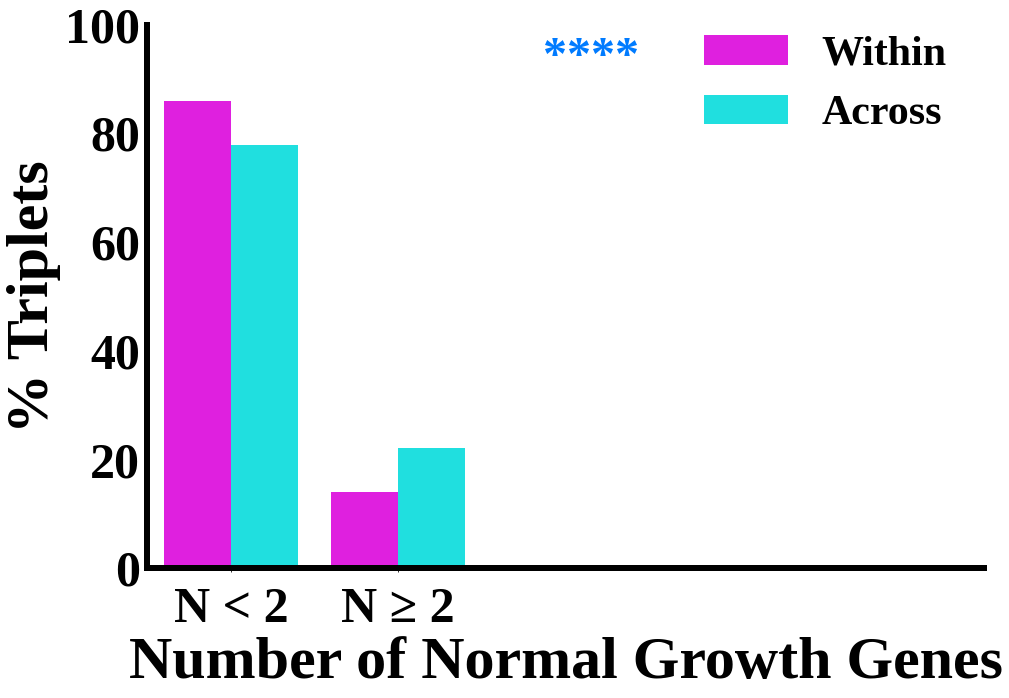

In [21]:
Ms = compute_obs_freq("../generated-data/dataset_yeast_pseudo_triplets.feather", "../generated-data/dataset_yeast_smf.feather")
plot_distrib(create_tgi_summary_smf(Ms, gi_labels=['Within','Across']), { 'Within' : 'magenta', 'Across' : 'cyan' }, 
            'Number of Normal Growth Genes', '% Triplets', 0,
            [0, 100], '#007bff', tick_label_size=50, xlim=[-0.5, 4.5])

## Sum LID vs Complex Interaction

Comparisons: 1, adjusted alpha: 0.050000
Within (15.04) vs. Across (12.90): 0.000000 [476.173569] (lens 5000 vs 5000)


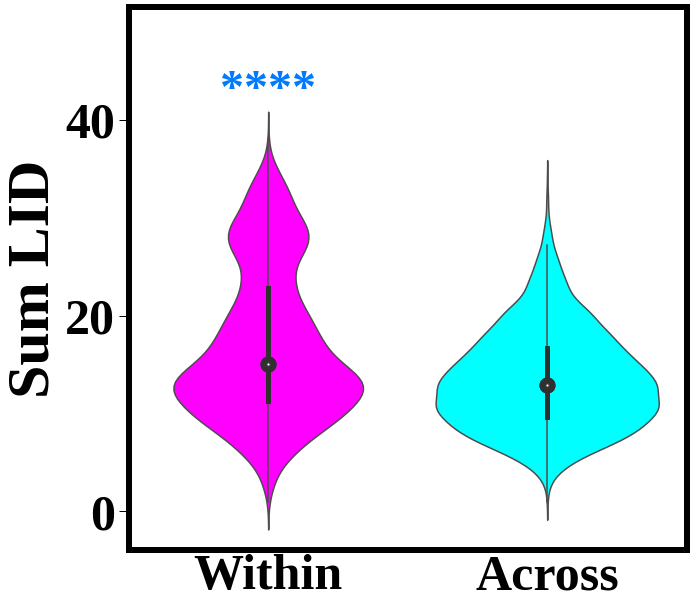

In [24]:
violin_plot("../generated-data/dataset_yeast_pseudo_triplets_mn.feather", 
            "topology-lid", "Sum LID", bins=np.array(['Within', 'Across']), 
            colors=['magenta','cyan'], star_colors=['magenta','#007bff'])

## Shortest Circuit Length vs Complex Interaction

# observation in 0: 5000
# observation in 1: 5000


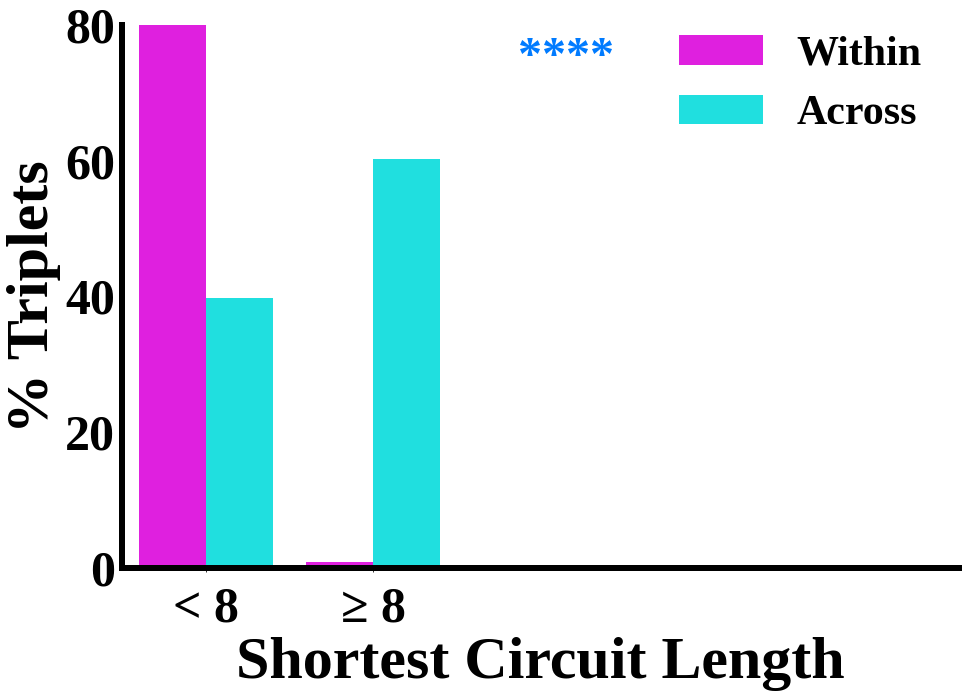

In [25]:
scl_freqs = compute_scl_freqs("../generated-data/dataset_yeast_pseudo_triplets_mn.feather")
plot_distrib(create_summary_scl_df(scl_freqs, 8, gi_labels=['Within','Across']), { 'Within' : 'magenta', 'Across' : 'cyan' }, 
            'Shortest Circuit Length', '% Triplets', 0,
            [0, 80], '#007bff', tick_label_size=50, xlim=[-0.5, 4.5])

## Shared sGO Terms vs Complex Interaction

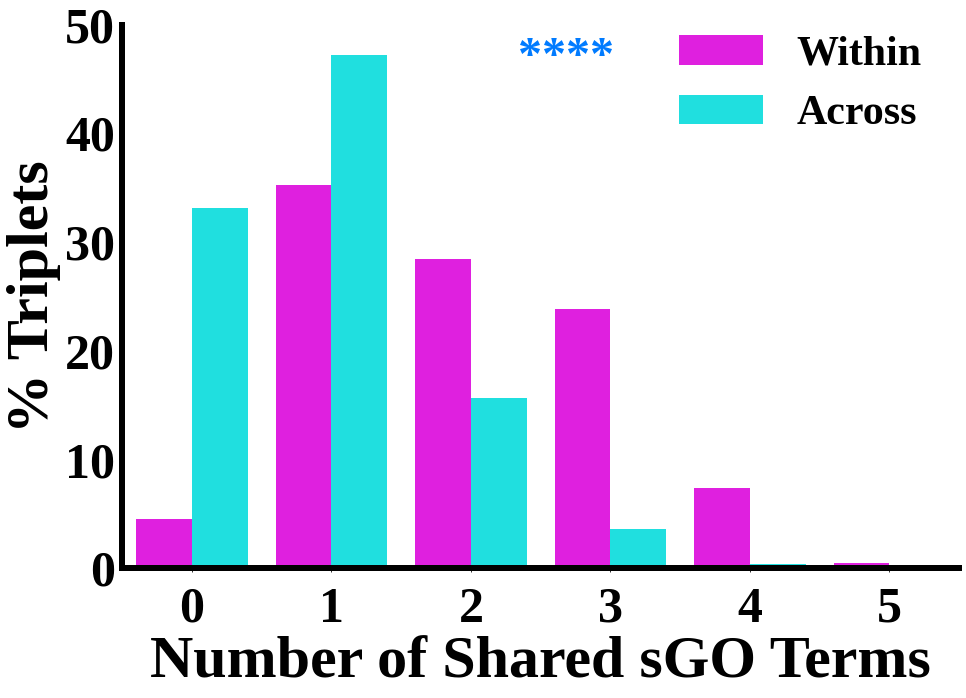

In [26]:
plot_distrib(create_tgi_shared_sgo_df(
                compute_tgi_shared_sgo("../generated-data/dataset_yeast_pseudo_triplets_mn.feather", 2),
                gi_labels=['Within','Across']), 
             { 'Within' : 'magenta', 'Across' : 'cyan' }, 
             'Number of Shared sGO Terms', '% Triplets', 0,
             [0, 50], '#007bff', tick_label_size=50, xlim=[-0.5, 5.5])

# Input Features Correlation

## Topology

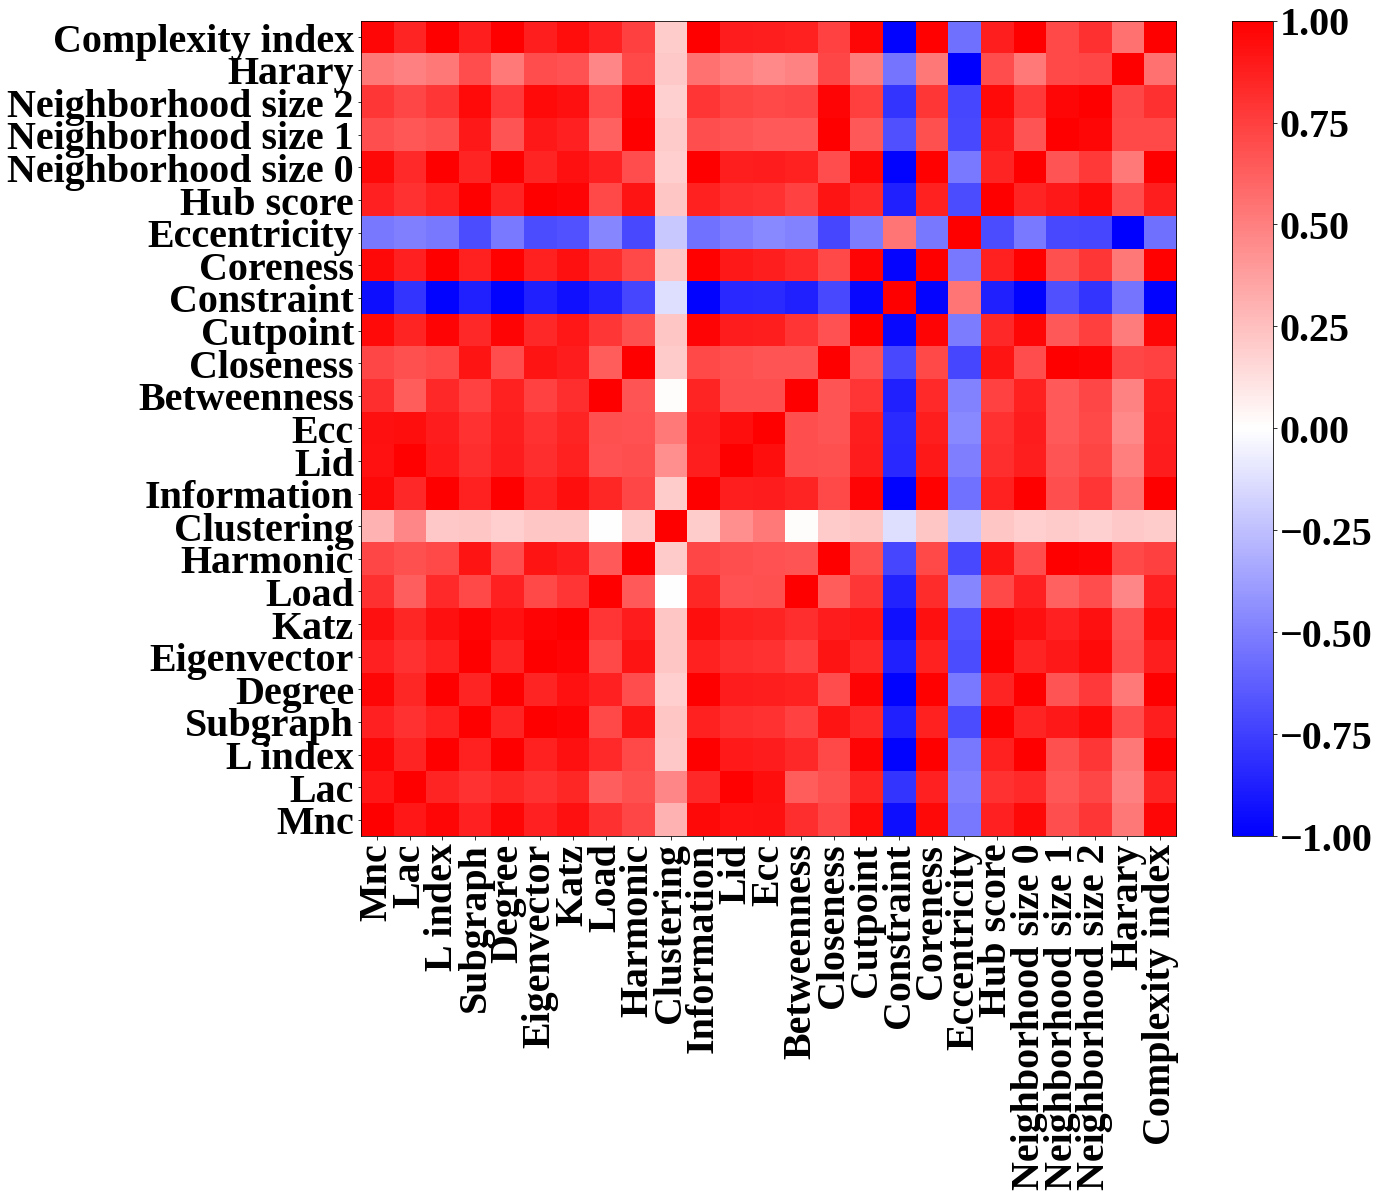

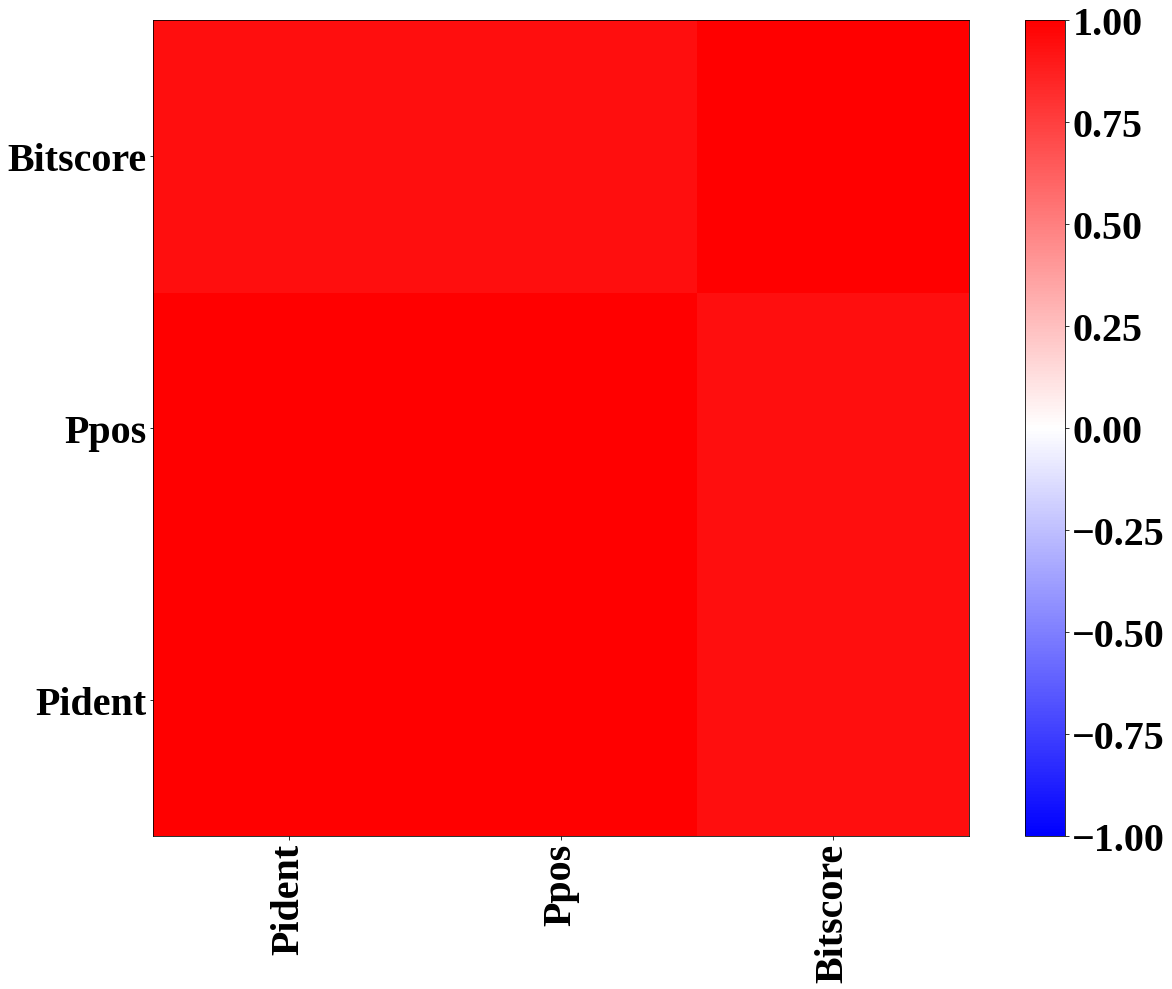

In [27]:
def fix_name(s):
    s = s.replace('_centrality','').replace('_cent','').capitalize()
    s = s.replace('_', ' ')
    return s

def plot_corr(task_path, feature):
    
    df = pd.read_feather(task_path)
    
    cols = df.columns[df.columns.str.startswith(feature)]
    
    sdf = df[cols]
    
    corr = sdf.corr('spearman')

    f, ax = plt.subplots(1,1, figsize=(20, 15))
    cax = ax.imshow(corr, cmap='bwr', vmin=-1, vmax=1, origin='lower')
    
    cbar = f.colorbar(cax)
    cbar.ax.tick_params(labelsize=40) 

    ticks = np.arange(0, len(cols))
    ax.set_xticks(ticks)
    plt.xticks(rotation=90)
    ax.set_yticks(ticks)
    
    col_names = cols.str.replace(feature,'')
    col_names = [fix_name(c) for c in col_names]
    ax.set_xticklabels(col_names, fontsize=40)
    ax.set_yticklabels(col_names, fontsize=40)
plot_corr('../generated-data/dataset_yeast_allppc.feather', 'topology-')
plot_corr('../generated-data/dataset_yeast_allppc.feather', 'redundancy-')